In [1]:
%reload_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import os
import pickle
import copy
from tqdm import tqdm

import pandas as pd
import numpy as np
from collections import OrderedDict
import itertools
from natsort import natsorted

# Regression and statistical tests
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.stats.outliers_influence import summary_table
from scipy.optimize import least_squares
from scipy.interpolate import interp1d
from linearmodels.panel import PanelOLS, PooledOLS, RandomEffects
from linearmodels.panel import compare
import pymannkendall as mk

import ipywidgets as widgets
from ipywidgets import interact, Button, Output

from IPython.display import Markdown, Image, display
def printmd(string):
    """Embed the input string into Markdown."""
    display(Markdown(string))

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rc
rc('text', usetex=True)

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from matplotlib.colors import ListedColormap
import matplotlib.ticker as tick

import matplotlib.style as style
style.use('seaborn-notebook')
style.use('ggplot')
sns.set_style('whitegrid', {'grid.linestyle': 'dotted'})

parameters = {'axes.labelsize': 14, 'axes.titlesize': 14, 'figure.titlesize': 16,
              'xtick.labelsize': 12, 'ytick.labelsize': 12, 'legend.fontsize': 10,
              'xtick.major.pad': -0.5, 'xtick.minor.pad': -0.5,
              'ytick.major.pad': -0.5, 'ytick.minor.pad': -0.5,}

plt.rcParams.update(parameters)

In [3]:
from copy import deepcopy
from collections import deque

def flatten_list(nested_list):
    """Flatten an arbitrarily nested list (without recursion to avoid
    stack overflows). Returns a new list, the original list is unchanged."""
    q = deque()
    
    for current in nested_list:
        if isinstance(current, list):
            q.extendleft(reversed(current))
        else:
            q.appendleft(current)
        while q:
            toFlat = q.popleft()
            if isinstance(toFlat, list):
                q.extendleft(reversed(toFlat))
            else:
                yield toFlat
                
def bold_text(string):
    """Render the input string as bold.
    Returns a new string, the original string is unchanged."""
    
    return r'\textbf{{{}}}'.format(string)

def int_col(df):
    """Casting int columns into int"""

    for col in df.select_dtypes(include='number'):
            if (df[col] % 1  == 0).all():
                df[col] = df[col].astype(int)

# Lin et al. data

Paper: _Evidence of general economic principles of bargaining and trade from 2,000 classroom experiments_ (https://www.nature.com/articles/s41562-020-0916-8)

In [4]:
df = pd.read_stata('Data/market.dta')
df = df.replace('', np.nan, regex=True)

Remarks:
- ```SessionID``` redundant as it is encoded in ```MarketID```;
- ```MarketID_period``` redundant as it encodes ```period``` and ```MarketID```.

In [5]:
(df['SessionID'] == df['MarketID'].apply(lambda mid: int(mid/1000))).all()
(df['MarketID_period'] == (df['period'] + df['MarketID']*100)).all()

True

True

In [6]:
df.drop('MarketID_period', axis=1, inplace=True)

In [7]:
int_col(df)

The data is a concatenation of five datasets storing information on the **sessions**, the **markets**, the **players**, the **order book**, and the **deals**.

## Extract relevant information

### Session profiles

Remarks:
- ```group``` is redundant as it can be extracted from ```MarketID``` and ```SessionID```

In [8]:
(df['group'] == df['MarketID'] - df['SessionID']*1000).all()

True

In [9]:
df_sessionProfile = df[['SessionID', 'location_label', 'type_label', 'fund_label', 'class_label', 'time_label']].copy()
df_sessionProfile.drop_duplicates(inplace=True)

Sanity check: no row contains ```NaN```s

In [10]:
df_sessionProfile[df_sessionProfile.isna().any(axis=1)]

,SessionID,location_label,type_label,fund_label,class_label,time_label


In [11]:
df_sessionProfile

,SessionID,location_label,type_label,fund_label,class_label,time_label
0,1,102,1,2,1,2
120,2,103,1,2,2,2
474,3,200,1,2,1,2
921,4,104,1,2,2,2
1529,5,104,1,2,8,1
...,...,...,...,...,...,...
975632,2542,502,1,2,2,2
975762,2544,200,1,2,1,2
976243,2547,103,1,2,1,2
977319,2549,103,1,1,1,2


In [12]:
df.drop(['SessionID', 'group', 'location_label', 'type_label', 'fund_label', 'class_label', 'time_label'], axis=1, inplace=True)

### Market profiles

In [13]:
df_marketProfile = df[['MarketID', 'eq_price', 'eq_quantity', 'optimalconsumersurplus', 'optimalproducersurplus',
                       'optimal_surplus', 'Number_players', 'default', 'mean_experience_robot', 'mean_experience_nonrobot',
                       'Quantity', 'ConsumerSurplus', 'ProducerSurplus', 'surplus', 'efficiency']].copy()
df_marketProfile.drop_duplicates(inplace=True)

Sanity check: no row contains ```NaN```s

In [14]:
df_marketProfile[df_marketProfile.isna().any(axis=1)]

,MarketID,eq_price,eq_quantity,optimalconsumersurplus,optimalproducersurplus,optimal_surplus,Number_players,default,mean_experience_robot,mean_experience_nonrobot,Quantity,ConsumerSurplus,ProducerSurplus,surplus,efficiency


In [15]:
int_col(df_marketProfile)

In [16]:
df_marketProfile

,MarketID,eq_price,eq_quantity,optimalconsumersurplus,optimalproducersurplus,optimal_surplus,Number_players,default,mean_experience_robot,mean_experience_nonrobot,Quantity,ConsumerSurplus,ProducerSurplus,surplus,efficiency
0,1001,103,17,894,665,1559,25,0,0.0,0.000000,17,1056,167,1223,0.784477
120,2001,66,12,156,288,444,15,0,0.0,0.866667,15,65,225,290,0.653153
283,2002,66,12,156,288,444,15,0,0.0,0.466667,22,-206,260,54,0.121622
455,2003,64,2,38,56,94,2,0,0.0,1.000000,2,26,68,94,1.000000
474,3001,112,13,260,416,676,10,1,0.0,0.000000,12,354,283,637,0.942308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
977085,2547011,112,13,260,416,676,10,1,0.0,1.000000,11,191,404,595,0.880178
977168,2547012,112,13,260,416,676,10,1,0.0,1.000000,12,335,284,619,0.915680
977238,2547013,112,13,260,416,676,10,1,0.0,0.900000,13,172,440,612,0.905325
977319,2549001,137,9,405,513,918,6,0,0.0,3.000000,9,583,335,918,1.000000


In [17]:
df.drop(['eq_price', 'eq_quantity', 'optimalconsumersurplus', 'optimalproducersurplus', 'optimal_surplus',
         'Number_players', 'default', 'mean_experience_robot', 'mean_experience_nonrobot',
         'Quantity', 'ConsumerSurplus', 'ProducerSurplus', 'surplus', 'efficiency'], axis=1, inplace=True)

### Player profiles

Remarks:
- ```userid ...``` stores (globally) unique user IDs;
- ```player(id) ...``` stores IDs which are unique within session-periods.

WLOG, we will only use ```userid ...```.

Moreover, ```... _profile``` stores the IDs of _all_ users recruited for the game (who did not necessarily participate in it). They can be found in ```df_playerProfile``` below.

Sanity check:
- the set of ```userid```s/```player```s is indeed a subset of the set of ```userid_profile```s/```playerid_profile```s;
- the number of ```userid (...)```s matches the number of ```player(id) (...)```s.

In [18]:
for mid, df_market in df.groupby(['MarketID']):
    if not set(df_market['userid'].dropna()).issubset(set(df_market['userid_profile'].dropna())):
        print('userids not a subset in market {}'.format(mid))
        
    if not set(df_market['player'].dropna()).issubset(set(df_market['playerid_profile'].dropna())):
        print('playerids not a subset in market {}'.format(mid))
        
    if len(set(df_market['userid_profile'].dropna())) != len(set(df_market['playerid_profile'].dropna())):
        print('the number of userid_profiles does not match the number of playerid_profiles in market {}'.format(mid))
        
for (mid, period), df_mp in df.groupby(['MarketID', 'period']):
    if len(set(df_mp['userid'].dropna())) != len(set(df_mp['player'].dropna())):
        print('the number of userids does not match the number of players in market {} in period {}'.format(mid, period))

Remark: there seems to be a mismatch—while ```Number_players``` (which can be found in ```df_marketProfile```) mostly equals the number of players in ```df_playerProfile```, it can also be smaller.

In [19]:
compare_nplayers = {
    'marketProfile_vs_orderBook': [0,0,0],
    'marketProfile_vs_playerProfile': [0,0,0]
    }

for mid, df_market in df.groupby(['MarketID']):
    nplayers_marketProfile = df_marketProfile[df_marketProfile['MarketID'] == mid]['Number_players'].iloc[0]    
    nplayers_orderBook = len(set(df_market['userid'].dropna()))
    nplayers_playerProfile = len(set(df_market['userid_profile'].dropna()))
    
    if nplayers_marketProfile < nplayers_orderBook:
        compare_nplayers['marketProfile_vs_orderBook'][0] += 1
    elif nplayers_marketProfile == nplayers_orderBook:
        compare_nplayers['marketProfile_vs_orderBook'][1] += 1
    else:
        compare_nplayers['marketProfile_vs_orderBook'][2] += 1

    if nplayers_marketProfile < nplayers_playerProfile:
        compare_nplayers['marketProfile_vs_playerProfile'][0] += 1
    elif nplayers_marketProfile == nplayers_playerProfile:
        compare_nplayers['marketProfile_vs_playerProfile'][1] += 1
    else:
        compare_nplayers['marketProfile_vs_playerProfile'][2] += 1

compare_nplayers

{'marketProfile_vs_orderBook': [54, 4789, 966],
 'marketProfile_vs_playerProfile': [69, 5740, 0]}

In [20]:
df_playerProfile = df[['MarketID', 'period', 'userid_profile', 'role', 'payoff', 'valuecost']].drop_duplicates()
df_playerProfile.dropna(inplace=True, how='all')
df_playerProfile = df_playerProfile[~df_playerProfile.isnull().any(axis=1)]
df_playerProfile['valuecost'] = df_playerProfile['valuecost'].apply(lambda v: tuple(int(x) for x in v.split('-')))
df_playerProfile['lenval'] = df_playerProfile['valuecost'].apply(len)

In [21]:
df_playerProfile

,MarketID,period,userid_profile,role,payoff,valuecost,lenval
95,1001,1,162499.0,seller,0.0,"(78, 138)",2
96,1001,1,158368.0,seller,-69.0,"(70, 130)",2
97,1001,1,159402.0,buyer,35.0,"(150, 75)",2
98,1001,1,161501.0,seller,0.0,"(74, 134)",2
99,1001,1,163746.0,buyer,0.0,"(145, 70)",2
...,...,...,...,...,...,...,...
977405,2550001,1,33753.0,seller,16.0,"(84,)",1
977406,2550001,1,33747.0,buyer,24.0,"(124,)",1
977407,2550001,1,33751.0,seller,50.0,"(76,)",1
977408,2550001,1,33756.0,buyer,33.0,"(132,)",1


Remark: players' market roles and/or valuation(s) are not necessarily constant across periods

In [22]:
nonConst_side = 0
nonConst_val = 0

for (mid, uid), df_player in df_playerProfile.groupby(['MarketID', 'userid_profile']):
    if len(set(df_player['role'])) > 1:
        nonConst_side += 1
    
    if len(set(df_player['valuecost'])) > 1:
        nonConst_val += 1
        
nonConst_side
nonConst_val

6850

7416

### Order book & deals

In [23]:
df = df[df['role'].isna()].copy()
df.drop(columns=['userid_profile', 'playerid_profile', 'role', 'payoff', 'valuecost'], axis=1, inplace=True)

In [24]:
df_deals = df[df['player'].isna()].dropna(axis=1, how='all')
df_orderBook = df[~df['player'].isna()].dropna(axis=1, how='all')

In [25]:
int_col(df_orderBook)
int_col(df_deals)

In [26]:
df_orderBook
df_deals

,MarketID,period,userid,player,playerrole,unit,orderid,buysell,bidask,offer_time,status,transactedprice
17,1001,1,158698,10,Seller,1,1,Sell,113,19778,CANCELLED,--
18,1001,1,157391,6,Seller,1,2,Sell,100,20918,FILLED,100
19,1001,1,162494,12,Seller,1,3,Sell,115,26785,CANCELLED,--
20,1001,1,159676,3,Buyer,1,4,Buy,190,29933,FILLED,100
21,1001,1,158698,10,Seller,2,5,Sell,115,31731,CANCELLED,--
...,...,...,...,...,...,...,...,...,...,...,...,...
977391,2550001,1,33758,11,Buyer,3,26,Buy,100,86003,FILLED,100
977392,2550001,1,33754,10,Seller,4,27,Sell,99,90037,FILLED,99
977393,2550001,1,33756,9,Buyer,3,28,Buy,95,96358,CANCELLED,--
977394,2550001,1,33756,9,Buyer,4,29,Buy,95,101234,CANCELLED,--


,MarketID,period,transactionid,sellorderid,bidorderid,selleruserid,buyeruserid,time,sideinitiated,sellercost,buyervalue,price
0,1001,1,1,2,4,157391,159676,29933,buy-side,42,195,100
1,1001,1,2,12,8,162494,158005,38530,sell-side,54,170,70
2,1001,1,3,9,13,159375,162496,39687,buy-side,30,185,74
3,1001,1,4,14,17,158368,159676,46774,buy-side,70,120,95
4,1001,1,5,20,18,160540,159402,52125,sell-side,66,150,88
...,...,...,...,...,...,...,...,...,...,...,...,...
977361,2550001,1,3,13,8,33750,33755,29272,sell-side,50,108,80
977362,2550001,1,4,18,17,33745,33747,42824,sell-side,68,124,100
977363,2550001,1,5,23,22,33749,33746,66777,sell-side,100,100,93
977364,2550001,1,6,25,26,33753,33758,86003,buy-side,84,140,100


## Restructure the data

In [27]:
df_orderBook.drop('player', axis=1, inplace=True)
df_orderBook.rename({
    'MarketID': 'treatment',
    'period': 'round',
    'userid': 'id',
    'playerrole': 'side',
    'offer_time': 'time',
    'transactedprice': 'price',
    'bidask': 'bid'
    }, axis=1, inplace=True)

In [28]:
df_orderBook

,treatment,round,id,side,unit,orderid,buysell,bid,time,status,price
17,1001,1,158698,Seller,1,1,Sell,113,19778,CANCELLED,--
18,1001,1,157391,Seller,1,2,Sell,100,20918,FILLED,100
19,1001,1,162494,Seller,1,3,Sell,115,26785,CANCELLED,--
20,1001,1,159676,Buyer,1,4,Buy,190,29933,FILLED,100
21,1001,1,158698,Seller,2,5,Sell,115,31731,CANCELLED,--
...,...,...,...,...,...,...,...,...,...,...,...
977391,2550001,1,33758,Buyer,3,26,Buy,100,86003,FILLED,100
977392,2550001,1,33754,Seller,4,27,Sell,99,90037,FILLED,99
977393,2550001,1,33756,Buyer,3,28,Buy,95,96358,CANCELLED,--
977394,2550001,1,33756,Buyer,4,29,Buy,95,101234,CANCELLED,--


Remarks: there is a one-to-one correspondence between ```buysell``` and ```side```

In [29]:
(df_orderBook.apply(lambda row: row['side'][0:3] == row['buysell'][0:3], axis=1)).all()

True

In [30]:
df_orderBook.drop('buysell', axis=1, inplace=True)

In [31]:
df_orderBook = df_orderBook[['treatment', 'round', 'time', 'id', 'side', 'bid', 'price', 'unit', 'orderid', 'status']]

In [32]:
df_orderBook.replace('--', np.nan, inplace=True)

In [33]:
df_orderBook

,treatment,round,time,id,side,bid,price,unit,orderid,status
17,1001,1,19778,158698,Seller,113,NaN,1,1,CANCELLED
18,1001,1,20918,157391,Seller,100,100,1,2,FILLED
19,1001,1,26785,162494,Seller,115,NaN,1,3,CANCELLED
20,1001,1,29933,159676,Buyer,190,100,1,4,FILLED
21,1001,1,31731,158698,Seller,115,NaN,2,5,CANCELLED
...,...,...,...,...,...,...,...,...,...,...
977391,2550001,1,86003,33758,Buyer,100,100,3,26,FILLED
977392,2550001,1,90037,33754,Seller,99,99,4,27,FILLED
977393,2550001,1,96358,33756,Buyer,95,NaN,3,28,CANCELLED
977394,2550001,1,101234,33756,Buyer,95,NaN,4,29,CANCELLED


### Add valuations to the order book

**Is the length of the valuation tuple constant across all periods of a market and is it the same for all players?**

In [34]:
valLengths = df_playerProfile.groupby(['MarketID'])['lenval']

print('Markets with varying valuation tuple lengths')
valLengths.nunique()[valLengths.nunique() != 1]

violatingPlayers = []

for market in valLengths.nunique()[valLengths.nunique() != 1].index:
    df_market = df_playerProfile[df_playerProfile['MarketID'] == market]
    df_market
    
    df_market['lenval'].value_counts()
    violatingPlayers.extend((market, player) for player in df_market[df_market['lenval'] != df_market['lenval'].median()]['userid_profile'])

Markets with varying valuation tuple lengths


MarketID
246001     2
945001     2
1732010    2
2019001    2
Name: lenval, dtype: int64

,MarketID,period,userid_profile,role,payoff,valuecost,lenval
80853,246001,1,47370.0,buyer,30.0,"(150, 135, 120)",3
80854,246001,1,47499.0,seller,0.0,"(50, 75, 100)",3
80855,246001,1,47400.0,buyer,0.0,"(147, 147, 132, 132, 117, 117)",6
80856,246001,1,47419.0,seller,0.0,"(55, 80, 105)",3
80857,246001,1,47203.0,buyer,0.0,"(144, 129, 114)",3
80858,246001,1,47406.0,seller,60.0,"(60, 85, 110)",3
80859,246001,1,47256.0,buyer,0.0,"(141, 126, 111)",3
80860,246001,1,47245.0,seller,0.0,"(65, 90, 115)",3
80861,246001,1,47234.0,buyer,0.0,"(138, 123, 108)",3
80862,246001,1,47330.0,seller,0.0,"(70, 95, 120)",3


3    9
6    1
Name: lenval, dtype: int64

,MarketID,period,userid_profile,role,payoff,valuecost,lenval
359997,945001,1,47554.0,seller,62.0,"(22, 37, 52, 67)",4
359998,945001,1,47572.0,buyer,39.0,"(68, 53, 38, 23)",4
359999,945001,1,47578.0,seller,42.0,"(23, 38, 53, 68)",4
360000,945001,1,47574.0,buyer,12.0,"(67, 52, 37, 22)",4
360001,945001,1,47573.0,seller,18.0,"(20, 35, 50, 65)",4
360002,945001,1,47556.0,buyer,33.0,"(70, 55, 40, 25)",4
360003,945001,1,47551.0,seller,56.0,"(21, 36, 51, 66)",4
360004,945001,1,47563.0,buyer,-152.0,"(69, 54, 39, 24)",4
360005,945001,1,47577.0,seller,0.0,"(24, 39, 54, 69)",4
360006,945001,1,47569.0,buyer,84.0,"(80, 65, 50, 35)",4


4    28
8     1
Name: lenval, dtype: int64

,MarketID,period,userid_profile,role,payoff,valuecost,lenval
679877,1732010,1,47415.0,buyer,0.0,"(150, 135, 120)",3
679878,1732010,1,47293.0,seller,22.0,"(50, 75, 100)",3
679879,1732010,1,47365.0,buyer,167.0,"(147, 132, 117)",3
679880,1732010,1,47483.0,seller,22.0,"(55, 55, 80, 80, 105, 105)",6
679881,1732010,1,47495.0,buyer,118.0,"(144, 129, 114)",3
679882,1732010,1,47413.0,seller,13.0,"(60, 85, 110)",3
679883,1732010,1,47493.0,buyer,139.0,"(141, 126, 111)",3
679884,1732010,1,47463.0,seller,-6.0,"(65, 90, 115)",3
679885,1732010,1,47281.0,buyer,0.0,"(138, 123, 108)",3
679886,1732010,1,47205.0,seller,0.0,"(70, 95, 120)",3


3    9
6    1
Name: lenval, dtype: int64

,MarketID,period,userid_profile,role,payoff,valuecost,lenval
794876,2019001,1,42101.0,buyer,35.0,"(138, 118, 103)",3
794877,2019001,1,42272.0,buyer,24.0,"(134, 119, 104)",3
794878,2019001,1,42291.0,seller,46.0,"(66, 91, 116)",3
794879,2019001,1,42315.0,buyer,0.0,"(135, 120, 105)",3
794880,2019001,1,42161.0,seller,36.0,"(65, 90, 115)",3
...,...,...,...,...,...,...,...
795046,2019001,1,42217.0,seller,43.0,"(60, 85, 105)",3
795047,2019001,1,42266.0,buyer,-37.0,"(146, 131, 111)",3
795048,2019001,1,42294.0,seller,0.0,"(64, 89, 109)",3
795049,2019001,1,42037.0,buyer,22.0,"(130, 115, 100)",3


3    173
6      2
Name: lenval, dtype: int64

In [35]:
violatingPlayers

[(246001, 47400.0),
 (945001, 47576.0),
 (1732010, 47483.0),
 (2019001, 42239.0),
 (2019001, 42154.0)]

It seems likely that these players were mistakenly assigned too many items.

In [36]:
for market, idx in violatingPlayers:
    print('Player {} in market {}'.format(idx, market))
    df_playerProfile[(df_playerProfile['userid_profile'] == idx) & (df_playerProfile['MarketID'] == market)]
    df_orderBook[(df_orderBook['id'] == idx) & (df_orderBook['treatment'] == market)]
    df_deals[((df_deals['buyeruserid'] == idx) | (df_deals['selleruserid'] == idx)) & (df_deals['MarketID'] == market)]
    print('\n')

Player 47400.0 in market 246001


,MarketID,period,userid_profile,role,payoff,valuecost,lenval
80855,246001,1,47400.0,buyer,0.0,"(147, 147, 132, 132, 117, 117)",6


,treatment,round,time,id,side,bid,price,unit,orderid,status


,MarketID,period,transactionid,sellorderid,bidorderid,selleruserid,buyeruserid,time,sideinitiated,sellercost,buyervalue,price




Player 47576.0 in market 945001


,MarketID,period,userid_profile,role,payoff,valuecost,lenval
360023,945001,1,47576.0,seller,46.0,"(18, 18, 33, 33, 48, 48, 63, 63)",8


,treatment,round,time,id,side,bid,price,unit,orderid,status
359822,945001,1,24291,47576,Seller,64,64,1,7,FILLED


,MarketID,period,transactionid,sellorderid,bidorderid,selleruserid,buyeruserid,time,sideinitiated,sellercost,buyervalue,price
359785,945001,1,14,7,50,47576,47552,55098,buy-side,18,46,64




Player 47483.0 in market 1732010


,MarketID,period,userid_profile,role,payoff,valuecost,lenval
679880,1732010,1,47483.0,seller,22.0,"(55, 55, 80, 80, 105, 105)",6


,treatment,round,time,id,side,bid,price,unit,orderid,status
679838,1732010,1,10596,47483,Seller,134,NaN,1,1,OPEN
679841,1732010,1,22043,47483,Seller,143,NaN,1,4,CANCELLED
679844,1732010,1,39467,47483,Seller,113,NaN,2,7,CANCELLED
679848,1732010,1,55402,47483,Seller,MARKET ORDER,56,3,11,FILLED
679851,1732010,1,68748,47483,Seller,98,NaN,3,14,CANCELLED
679860,1732010,1,104329,47483,Seller,74,74,4,23,FILLED
679876,1732010,1,171497,47483,Seller,MARKET ORDER,82,4,39,FILLED


,MarketID,period,transactionid,sellorderid,bidorderid,selleruserid,buyeruserid,time,sideinitiated,sellercost,buyervalue,price
679832,1732010,1,2,11,8,47483,47365,55402,sell-side,55,132,56
679833,1732010,1,3,23,24,47483,47493,109222,buy-side,55,141,74
679837,1732010,1,7,39,38,47483,47495,171497,sell-side,80,129,82




Player 42239.0 in market 2019001


,MarketID,period,userid_profile,role,payoff,valuecost,lenval
794903,2019001,1,42239.0,buyer,0.0,"(139, 104, 119, 119, 139, 139)",6


,treatment,round,time,id,side,bid,price,unit,orderid,status


,MarketID,period,transactionid,sellorderid,bidorderid,selleruserid,buyeruserid,time,sideinitiated,sellercost,buyervalue,price




Player 42154.0 in market 2019001


,MarketID,period,userid_profile,role,payoff,valuecost,lenval
795002,2019001,1,42154.0,buyer,96.0,"(141, 141, 126, 126, 111, 111)",6


,treatment,round,time,id,side,bid,price,unit,orderid,status
794253,2019001,1,36282,42154,Buyer,52,52,1,14,FILLED
794334,2019001,1,70751,42154,Buyer,136,136,1,95,FILLED
794405,2019001,1,85803,42154,Buyer,124,124,1,166,FILLED


,MarketID,period,transactionid,sellorderid,bidorderid,selleruserid,buyeruserid,time,sideinitiated,sellercost,buyervalue,price
794108,2019001,1,7,29,14,42223,42154,48855,sell-side,74,141,52
794120,2019001,1,19,97,95,42209,42154,71705,sell-side,61,141,136
794138,2019001,1,37,180,166,41958,42154,89067,sell-side,79,126,124


None of these players made more deals than others did; hence, their valuation tuples can be truncated so that their lengths match the rest.

In [37]:
for market, idx in violatingPlayers:
    df_market = df_playerProfile[(df_playerProfile['MarketID'] == market)]
    
    standard_length = int(df_market['lenval'].median())
    
    _filter = (df_playerProfile['userid_profile'] == idx) & (df_playerProfile['MarketID'] == market)

    df_playerProfile.loc[_filter, 'valuecost'] = df_playerProfile.loc[_filter, 'valuecost'].apply(lambda x: x[0:standard_length])
    df_playerProfile.loc[_filter, 'lenval'] = standard_length

In [38]:
for market, idx in violatingPlayers:
    df_playerProfile[(df_playerProfile['userid_profile'] == idx) & (df_playerProfile['MarketID'] == market)]

,MarketID,period,userid_profile,role,payoff,valuecost,lenval
80855,246001,1,47400.0,buyer,0.0,"(147, 147, 132)",3


,MarketID,period,userid_profile,role,payoff,valuecost,lenval
360023,945001,1,47576.0,seller,46.0,"(18, 18, 33, 33)",4


,MarketID,period,userid_profile,role,payoff,valuecost,lenval
679880,1732010,1,47483.0,seller,22.0,"(55, 55, 80)",3


,MarketID,period,userid_profile,role,payoff,valuecost,lenval
794903,2019001,1,42239.0,buyer,0.0,"(139, 104, 119)",3


,MarketID,period,userid_profile,role,payoff,valuecost,lenval
795002,2019001,1,42154.0,buyer,96.0,"(141, 141, 126)",3


The lengths of the valuation tuples are now constant across all periods and all players within a single market (uniquely determined by ```MarketID```). 

In [39]:
updateBids = pd.merge(df_orderBook, df_deals,  how='outer', left_on=['treatment', 'round', 'orderid'], right_on = ['MarketID','period', 'bidorderid'])
updateAsks = pd.merge(df_orderBook, df_deals,  how='outer', left_on=['treatment', 'round', 'orderid'], right_on = ['MarketID','period', 'sellorderid'])

df_orderBook = updateBids.combine_first(updateAsks)

In [40]:
df_orderBook

,treatment,round,time_x,id,side,bid,price_x,unit,orderid,status,...,transactionid,sellorderid,bidorderid,selleruserid,buyeruserid,time_y,sideinitiated,sellercost,buyervalue,price_y
0,1001,1,19778,158698,Seller,113,NaN,1,1,CANCELLED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1001,1,20918,157391,Seller,100,100,1,2,FILLED,...,1.0,2.0,4.0,157391.0,159676.0,29933.0,buy-side,42.0,195.0,100.0
2,1001,1,26785,162494,Seller,115,NaN,1,3,CANCELLED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1001,1,29933,159676,Buyer,190,100,1,4,FILLED,...,1.0,2.0,4.0,157391.0,159676.0,29933.0,buy-side,42.0,195.0,100.0
4,1001,1,31731,158698,Seller,115,NaN,2,5,CANCELLED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707743,2550001,1,86003,33758,Buyer,100,100,3,26,FILLED,...,6.0,25.0,26.0,33753.0,33758.0,86003.0,buy-side,84.0,140.0,100.0
707744,2550001,1,90037,33754,Seller,99,99,4,27,FILLED,...,7.0,27.0,30.0,33754.0,33756.0,119105.0,buy-side,60.0,132.0,99.0
707745,2550001,1,96358,33756,Buyer,95,NaN,3,28,CANCELLED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
707746,2550001,1,101234,33756,Buyer,95,NaN,4,29,CANCELLED,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
len(df_orderBook[df_orderBook['bid'] == 'MARKET ORDER'])

108000

In [42]:
df_orderBook['bid'] = df_orderBook['bid'].replace({'MARKET ORDER': -1})
df_orderBook['bid'] = df_orderBook['bid'].astype(float)
int_col(df_orderBook)

In [43]:
df_orderBook['price_x'] = df_orderBook['price_x'].astype(float)
df_orderBook['price_y'] = df_orderBook['price_y'].astype(float)

In [44]:
df_orderBook.drop(['transactionid', 'sellorderid', 'bidorderid', 'MarketID', 'period', 'sideinitiated'], axis=1, inplace=True)

In [45]:
df_orderBook

,treatment,round,time_x,id,side,bid,price_x,unit,orderid,status,selleruserid,buyeruserid,time_y,sellercost,buyervalue,price_y
0,1001,1,19778,158698,Seller,113,NaN,1,1,CANCELLED,NaN,NaN,NaN,NaN,NaN,NaN
1,1001,1,20918,157391,Seller,100,100.0,1,2,FILLED,157391.0,159676.0,29933.0,42.0,195.0,100.0
2,1001,1,26785,162494,Seller,115,NaN,1,3,CANCELLED,NaN,NaN,NaN,NaN,NaN,NaN
3,1001,1,29933,159676,Buyer,190,100.0,1,4,FILLED,157391.0,159676.0,29933.0,42.0,195.0,100.0
4,1001,1,31731,158698,Seller,115,NaN,2,5,CANCELLED,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707743,2550001,1,86003,33758,Buyer,100,100.0,3,26,FILLED,33753.0,33758.0,86003.0,84.0,140.0,100.0
707744,2550001,1,90037,33754,Seller,99,99.0,4,27,FILLED,33754.0,33756.0,119105.0,60.0,132.0,99.0
707745,2550001,1,96358,33756,Buyer,95,NaN,3,28,CANCELLED,NaN,NaN,NaN,NaN,NaN,NaN
707746,2550001,1,101234,33756,Buyer,95,NaN,4,29,CANCELLED,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
def update_valuation(row):
    if row['side'] == 'Buyer':
        val = row['buyervalue']
    else:
        val = row['sellercost']
        
    return val

def update_match_id(row):
    if row['side'] == 'Buyer':
        match_id = row['selleruserid']
    else:
        match_id = row['buyeruserid']
        
    return match_id
   
df_orderBook['valuation'] = df_orderBook.apply(update_valuation, axis=1)
df_orderBook['match_id'] = df_orderBook.apply(update_match_id, axis=1)

In [47]:
df_orderBook.drop(['selleruserid', 'buyeruserid', 'sellercost', 'buyervalue'], axis=1, inplace=True)
df_orderBook.rename({'time_y': 'match_time'}, axis=1, inplace=True)

"MARKET ORDER" bids—which correspond to players accepting deals—still need to be accounted for (these are now stored as -1 in the ```bid``` column). For now, set them to ```NaN``` and add "MARKET ORDER" to the status.

In [48]:
def marketOrder_rows(row):
    if row['bid'] < 0:
        return '{}, MARKET ORDER'.format(row['status'])
    else:
        return row['status']

df_orderBook['status'] = df_orderBook.apply(marketOrder_rows, axis=1)
df_orderBook['bid'] = df_orderBook['bid'].replace({-1: np.nan})

In [49]:
df_orderBook[df_orderBook['bid'].isna()]

,treatment,round,time_x,id,side,bid,price_x,unit,orderid,status,match_time,price_y,valuation,match_id
11,1001,1,38530,162494,Seller,NaN,70.0,4,12,"FILLED, MARKET ORDER",38530.0,70.0,54.0,158005.0
26,1001,1,57319,157391,Seller,NaN,96.0,1,27,"FILLED, MARKET ORDER",57319.0,96.0,102.0,161979.0
31,1001,1,61845,159402,Buyer,NaN,102.0,1,32,"FILLED, MARKET ORDER",61845.0,102.0,75.0,160542.0
34,1001,1,66395,160723,Buyer,NaN,119.0,1,35,"FILLED, MARKET ORDER",66395.0,119.0,165.0,160829.0
36,1001,1,66422,160969,Seller,NaN,100.0,1,37,"FILLED, MARKET ORDER",66422.0,100.0,62.0,155370.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707701,2549001,1,20930,40250,Buyer,NaN,120.0,2,9,"FILLED, MARKET ORDER",20930.0,120.0,194.0,40247.0
707704,2549001,1,27528,40250,Buyer,NaN,120.0,3,12,"FILLED, MARKET ORDER",27528.0,120.0,179.0,40247.0
707706,2549001,1,30324,40250,Buyer,NaN,118.0,3,14,"FILLED, MARKET ORDER",30324.0,118.0,164.0,40249.0
707708,2549001,1,32158,40245,Seller,NaN,111.0,2,16,"FILLED, MARKET ORDER",32158.0,111.0,50.0,40248.0


According to the order book, 10 players seem to have made one too many deal (see below). However, since these deals were not tracked in the deals table, the erroneous entries in the order book can be corrected easily.

In [50]:
missingPriceInformation = df_orderBook[~(df_orderBook['price_x'].eq(df_orderBook['price_y']) | (df_orderBook['price_x'].isna() & df_orderBook['price_y'].isna()))]
missingPriceInformation

,treatment,round,time_x,id,side,bid,price_x,unit,orderid,status,match_time,price_y,valuation,match_id
33383,146001,2,27597,35198,Buyer,90.0,90.0,2,77,FILLED,NaN,NaN,NaN,NaN
33395,146001,2,30117,35189,Seller,90.0,90.0,1,89,FILLED,NaN,NaN,NaN,NaN
35765,156003,3,85749,46330,Buyer,97.0,97.0,6,123,FILLED,NaN,NaN,NaN,NaN
35788,156003,3,117912,46247,Seller,NaN,97.0,1,146,"FILLED, MARKET ORDER",NaN,NaN,NaN,NaN
36559,156005,3,87629,46075,Buyer,74.0,74.0,5,136,FILLED,NaN,NaN,NaN,NaN
36589,156005,3,118373,46226,Seller,NaN,74.0,2,166,"FILLED, MARKET ORDER",NaN,NaN,NaN,NaN
249919,892001,1,11901087,43243,Buyer,56.0,56.0,4,22,FILLED,NaN,NaN,NaN,NaN
249943,892001,1,20942325,45068,Seller,NaN,56.0,3,46,"FILLED, MARKET ORDER",NaN,NaN,NaN,NaN
275074,992001,1,168113,72077,Seller,145.0,145.0,5,286,FILLED,NaN,NaN,NaN,NaN
275077,992001,1,175822,67339,Buyer,NaN,145.0,3,289,"FILLED, MARKET ORDER",NaN,NaN,NaN,NaN


In [51]:
for idx, row in missingPriceInformation.iterrows():
    print('Market {}, round {}, player {}'.format(row['treatment'], row['round'], row['id']))
    
    _filter = (df_playerProfile['MarketID'] == row['treatment']) & (df_playerProfile['period'] == row['round']) & (df_playerProfile['userid_profile'] == row['id'])
    
    lenVal = df_playerProfile[_filter]['lenval'].iloc[0]
    
    print('Length of valuation tuple: {}'.format(lenVal))
    
    _filter = (df_orderBook['treatment'] == row['treatment']) & (df_orderBook['round'] == row['round']) & (df_orderBook['id'] == row['id'])   
    
    print('Number of deals in the order book: {}'.format(df_orderBook[_filter]['price_x'].count()))
    print('Number of deals in the table with deals: {}'.format(df_orderBook[_filter]['price_y'].count()))    
    
    df_orderBook[_filter]

Market 146001, round 2, player 35198
Length of valuation tuple: 1
Number of deals in the order book: 2
Number of deals in the table with deals: 1


,treatment,round,time_x,id,side,bid,price_x,unit,orderid,status,match_time,price_y,valuation,match_id
33344,146001,2,15585,35198,Buyer,0.0,NaN,1,38,CANCELLED,NaN,NaN,NaN,NaN
33377,146001,2,26355,35198,Buyer,120.0,120.0,2,71,FILLED,28646.0,120.0,140.0,35686.0
33383,146001,2,27597,35198,Buyer,90.0,90.0,2,77,FILLED,NaN,NaN,NaN,NaN


Market 146001, round 2, player 35189
Length of valuation tuple: 1
Number of deals in the order book: 1
Number of deals in the table with deals: 0


,treatment,round,time_x,id,side,bid,price_x,unit,orderid,status,match_time,price_y,valuation,match_id
33395,146001,2,30117,35189,Seller,90.0,90.0,1,89,FILLED,NaN,NaN,NaN,NaN


Market 156003, round 3, player 46330
Length of valuation tuple: 3
Number of deals in the order book: 4
Number of deals in the table with deals: 3


,treatment,round,time_x,id,side,bid,price_x,unit,orderid,status,match_time,price_y,valuation,match_id
35662,156003,3,11206,46330,Buyer,21.0,NaN,1,20,CANCELLED,NaN,NaN,NaN,NaN
35690,156003,3,26190,46330,Buyer,59.0,NaN,2,48,CANCELLED,NaN,NaN,NaN,NaN
35699,156003,3,30101,46330,Buyer,NaN,161.0,3,57,"FILLED, MARKET ORDER",30101.0,161.0,149.0,46796.0
35713,156003,3,43504,46330,Buyer,71.0,NaN,3,71,CANCELLED,NaN,NaN,NaN,NaN
35729,156003,3,50410,46330,Buyer,71.0,NaN,4,87,CANCELLED,NaN,NaN,NaN,NaN
35744,156003,3,65634,46330,Buyer,NaN,135.0,5,102,"FILLED, MARKET ORDER",65634.0,135.0,129.0,46203.0
35760,156003,3,82907,46330,Buyer,97.0,NaN,5,118,CANCELLED,NaN,NaN,NaN,NaN
35765,156003,3,85749,46330,Buyer,97.0,97.0,6,123,FILLED,NaN,NaN,NaN,NaN
35769,156003,3,90311,46330,Buyer,NaN,126.0,6,127,"FILLED, MARKET ORDER",90311.0,126.0,109.0,46956.0


Market 156003, round 3, player 46247
Length of valuation tuple: 3
Number of deals in the order book: 3
Number of deals in the table with deals: 2


,treatment,round,time_x,id,side,bid,price_x,unit,orderid,status,match_time,price_y,valuation,match_id
35652,156003,3,9201,46247,Seller,NaN,65.0,1,10,"FILLED, MARKET ORDER",9202.0,65.0,64.0,46935.0
35722,156003,3,47843,46247,Seller,NaN,100.0,1,80,"FILLED, MARKET ORDER",47843.0,100.0,84.0,46361.0
35788,156003,3,117912,46247,Seller,NaN,97.0,1,146,"FILLED, MARKET ORDER",NaN,NaN,NaN,NaN


Market 156005, round 3, player 46075
Length of valuation tuple: 3
Number of deals in the order book: 4
Number of deals in the table with deals: 3


,treatment,round,time_x,id,side,bid,price_x,unit,orderid,status,match_time,price_y,valuation,match_id
36448,156005,3,17939,46075,Buyer,39.0,NaN,1,25,CANCELLED,NaN,NaN,NaN,NaN
36466,156005,3,28449,46075,Buyer,63.0,NaN,2,43,CANCELLED,NaN,NaN,NaN,NaN
36480,156005,3,35427,46075,Buyer,93.0,93.0,3,57,FILLED,36470.0,93.0,146.0,46370.0
36509,156005,3,51323,46075,Buyer,82.0,82.0,3,86,FILLED,60400.0,82.0,136.0,46428.0
36531,156005,3,67931,46075,Buyer,53.0,NaN,3,108,CANCELLED,NaN,NaN,NaN,NaN
36543,156005,3,77142,46075,Buyer,53.0,NaN,4,120,CANCELLED,NaN,NaN,NaN,NaN
36559,156005,3,87629,46075,Buyer,74.0,74.0,5,136,FILLED,NaN,NaN,NaN,NaN
36585,156005,3,114398,46075,Buyer,NaN,99.0,5,162,"FILLED, MARKET ORDER",114398.0,99.0,116.0,46334.0


Market 156005, round 3, player 46226
Length of valuation tuple: 3
Number of deals in the order book: 3
Number of deals in the table with deals: 2


,treatment,round,time_x,id,side,bid,price_x,unit,orderid,status,match_time,price_y,valuation,match_id
36472,156005,3,31990,46226,Seller,98.0,98.0,1,49,FILLED,33019.0,98.0,55.0,46130.0
36494,156005,3,43968,46226,Seller,109.0,NaN,1,71,CANCELLED,NaN,NaN,NaN,NaN
36513,156005,3,53619,46226,Seller,NaN,82.0,2,90,"FILLED, MARKET ORDER",53619.0,82.0,75.0,46350.0
36589,156005,3,118373,46226,Seller,NaN,74.0,2,166,"FILLED, MARKET ORDER",NaN,NaN,NaN,NaN


Market 892001, round 1, player 43243
Length of valuation tuple: 3
Number of deals in the order book: 4
Number of deals in the table with deals: 3


,treatment,round,time_x,id,side,bid,price_x,unit,orderid,status,match_time,price_y,valuation,match_id
249914,892001,1,11708809,43243,Buyer,0.0,NaN,1,17,CANCELLED,NaN,NaN,NaN,NaN
249915,892001,1,11727267,43243,Buyer,58.0,NaN,2,18,CANCELLED,NaN,NaN,NaN,NaN
249917,892001,1,11856383,43243,Buyer,NaN,85.0,3,20,"FILLED, MARKET ORDER",11856383.0,85.0,144.0,42948.0
249918,892001,1,11867833,43243,Buyer,58.0,NaN,3,21,CANCELLED,NaN,NaN,NaN,NaN
249919,892001,1,11901087,43243,Buyer,56.0,56.0,4,22,FILLED,NaN,NaN,NaN,NaN
249920,892001,1,11902908,43243,Buyer,56.0,NaN,4,23,CANCELLED,NaN,NaN,NaN,NaN
249922,892001,1,11959006,43243,Buyer,73.0,NaN,5,25,CANCELLED,NaN,NaN,NaN,NaN
249923,892001,1,12032249,43243,Buyer,NaN,110.0,6,26,"FILLED, MARKET ORDER",12032249.0,110.0,129.0,42948.0
249924,892001,1,12044312,43243,Buyer,73.0,73.0,6,27,FILLED,12094910.0,73.0,114.0,43001.0


Market 892001, round 1, player 45068
Length of valuation tuple: 3
Number of deals in the order book: 3
Number of deals in the table with deals: 2


,treatment,round,time_x,id,side,bid,price_x,unit,orderid,status,match_time,price_y,valuation,match_id
249940,892001,1,20734489,45068,Seller,110.0,NaN,1,43,CANCELLED,NaN,NaN,NaN,NaN
249941,892001,1,20837650,45068,Seller,NaN,99.0,2,44,"FILLED, MARKET ORDER",20837650.0,99.0,70.0,45242.0
249942,892001,1,20864953,45068,Seller,100.0,NaN,2,45,CANCELLED,NaN,NaN,NaN,NaN
249943,892001,1,20942325,45068,Seller,NaN,56.0,3,46,"FILLED, MARKET ORDER",NaN,NaN,NaN,NaN
249944,892001,1,20962131,45068,Seller,140.0,NaN,3,47,CANCELLED,NaN,NaN,NaN,NaN
249948,892001,1,177179320,45068,Seller,120.0,NaN,4,51,CANCELLED,NaN,NaN,NaN,NaN
249956,892001,1,273478485,45068,Seller,NaN,51.0,5,59,"FILLED, MARKET ORDER",273478485.0,51.0,95.0,45234.0


Market 992001, round 1, player 72077
Length of valuation tuple: 3
Number of deals in the order book: 4
Number of deals in the table with deals: 3


,treatment,round,time_x,id,side,bid,price_x,unit,orderid,status,match_time,price_y,valuation,match_id
274867,992001,1,47374,72077,Seller,160.0,NaN,1,79,CANCELLED,NaN,NaN,NaN,NaN
274922,992001,1,67891,72077,Seller,133.0,133.0,2,134,FILLED,68515.0,133.0,104.0,65701.0
274958,992001,1,84568,72077,Seller,139.0,139.0,2,170,FILLED,86182.0,139.0,124.0,73942.0
275017,992001,1,107825,72077,Seller,170.0,NaN,2,229,CANCELLED,NaN,NaN,NaN,NaN
275060,992001,1,136780,72077,Seller,153.0,NaN,3,272,CANCELLED,NaN,NaN,NaN,NaN
275071,992001,1,161181,72077,Seller,145.0,NaN,4,283,CANCELLED,NaN,NaN,NaN,NaN
275073,992001,1,165132,72077,Seller,145.0,145.0,5,285,FILLED,170241.0,145.0,144.0,67870.0
275074,992001,1,168113,72077,Seller,145.0,145.0,5,286,FILLED,NaN,NaN,NaN,NaN


Market 992001, round 1, player 67339
Length of valuation tuple: 3
Number of deals in the order book: 3
Number of deals in the table with deals: 2


,treatment,round,time_x,id,side,bid,price_x,unit,orderid,status,match_time,price_y,valuation,match_id
274834,992001,1,35249,67339,Buyer,108.0,NaN,1,46,CANCELLED,NaN,NaN,NaN,NaN
274893,992001,1,59161,67339,Buyer,NaN,135.0,2,105,"FILLED, MARKET ORDER",59161.0,135.0,208.0,67509.0
274976,992001,1,91228,67339,Buyer,110.0,NaN,2,188,CANCELLED,NaN,NaN,NaN,NaN
275055,992001,1,130274,67339,Buyer,NaN,143.0,3,267,"FILLED, MARKET ORDER",130274.0,143.0,188.0,66477.0
275077,992001,1,175822,67339,Buyer,NaN,145.0,3,289,"FILLED, MARKET ORDER",NaN,NaN,NaN,NaN


Market 1256002, round 1, player 101695
Length of valuation tuple: 1
Number of deals in the order book: 1
Number of deals in the table with deals: 0


,treatment,round,time_x,id,side,bid,price_x,unit,orderid,status,match_time,price_y,valuation,match_id
351398,1256002,1,29060,101695,Buyer,104.0,NaN,1,3,CANCELLED,NaN,NaN,NaN,NaN
351402,1256002,1,87372,101695,Buyer,106.0,106.0,2,7,FILLED,NaN,NaN,NaN,NaN


Market 1256002, round 1, player 101027
Length of valuation tuple: 1
Number of deals in the order book: 2
Number of deals in the table with deals: 1


,treatment,round,time_x,id,side,bid,price_x,unit,orderid,status,match_time,price_y,valuation,match_id
351400,1256002,1,53210,101027,Seller,165.0,165.0,1,5,FILLED,61258.0,165.0,56.0,101582.0
351403,1256002,1,91377,101027,Seller,NaN,106.0,1,8,"FILLED, MARKET ORDER",NaN,NaN,NaN,NaN


Market 1368001, round 1, player 34044
Length of valuation tuple: 1
Number of deals in the order book: 2
Number of deals in the table with deals: 1


,treatment,round,time_x,id,side,bid,price_x,unit,orderid,status,match_time,price_y,valuation,match_id
386803,1368001,1,32571,34044,Buyer,6.0,NaN,1,6,CANCELLED,NaN,NaN,NaN,NaN
386815,1368001,1,51096,34044,Buyer,90.0,90.0,2,18,FILLED,NaN,NaN,NaN,NaN
386816,1368001,1,52289,34044,Buyer,96.0,96.0,2,19,FILLED,52289.0,96.0,115.0,33999.0


Market 1368001, round 1, player 33997
Length of valuation tuple: 1
Number of deals in the order book: 1
Number of deals in the table with deals: 0


,treatment,round,time_x,id,side,bid,price_x,unit,orderid,status,match_time,price_y,valuation,match_id
386820,1368001,1,61211,33997,Seller,90.0,90.0,1,23,FILLED,NaN,NaN,NaN,NaN


Market 1731006, round 1, player 73645
Length of valuation tuple: 3
Number of deals in the order book: 4
Number of deals in the table with deals: 3


,treatment,round,time_x,id,side,bid,price_x,unit,orderid,status,match_time,price_y,valuation,match_id
490084,1731006,1,10210,73645,Seller,181.0,NaN,1,22,CANCELLED,NaN,NaN,NaN,NaN
490095,1731006,1,12411,73645,Seller,204.0,NaN,2,33,CANCELLED,NaN,NaN,NaN,NaN
490113,1731006,1,17265,73645,Seller,159.0,NaN,3,51,OPEN,NaN,NaN,NaN,NaN
490129,1731006,1,19794,73645,Seller,173.0,NaN,3,67,OPEN,NaN,NaN,NaN,NaN
490132,1731006,1,20369,73645,Seller,173.0,NaN,3,70,CANCELLED,NaN,NaN,NaN,NaN
490147,1731006,1,24184,73645,Seller,167.0,NaN,4,85,OPEN,NaN,NaN,NaN,NaN
490154,1731006,1,26072,73645,Seller,146.0,NaN,4,92,CANCELLED,NaN,NaN,NaN,NaN
490167,1731006,1,29339,73645,Seller,138.0,NaN,5,105,CANCELLED,NaN,NaN,NaN,NaN
490173,1731006,1,31749,73645,Seller,143.0,NaN,6,111,CANCELLED,NaN,NaN,NaN,NaN
490179,1731006,1,34355,73645,Seller,144.0,NaN,7,117,CANCELLED,NaN,NaN,NaN,NaN


Market 1731006, round 1, player 65948
Length of valuation tuple: 3
Number of deals in the order book: 1
Number of deals in the table with deals: 0


,treatment,round,time_x,id,side,bid,price_x,unit,orderid,status,match_time,price_y,valuation,match_id
490457,1731006,1,177840,65948,Buyer,128.0,115.0,1,395,FILLED,NaN,NaN,NaN,NaN


Market 1936002, round 1, player 66259
Length of valuation tuple: 3
Number of deals in the order book: 4
Number of deals in the table with deals: 3


,treatment,round,time_x,id,side,bid,price_x,unit,orderid,status,match_time,price_y,valuation,match_id
548672,1936002,1,15619,66259,Buyer,41.0,NaN,1,14,CANCELLED,NaN,NaN,NaN,NaN
548712,1936002,1,43565,66259,Buyer,54.0,NaN,2,54,CANCELLED,NaN,NaN,NaN,NaN
548729,1936002,1,50955,66259,Buyer,60.0,NaN,3,71,CANCELLED,NaN,NaN,NaN,NaN
548746,1936002,1,59474,66259,Buyer,77.0,77.0,4,88,FILLED,NaN,NaN,NaN,NaN
548762,1936002,1,69391,66259,Buyer,NaN,99.0,4,104,"FILLED, MARKET ORDER",69391.0,99.0,147.0,65771.0
548812,1936002,1,114172,66259,Buyer,96.0,96.0,4,154,FILLED,117519.0,96.0,130.0,66442.0
548833,1936002,1,135330,66259,Buyer,NaN,107.0,4,175,"FILLED, MARKET ORDER",135330.0,107.0,113.0,65287.0


Market 1936002, round 1, player 65983
Length of valuation tuple: 3
Number of deals in the order book: 3
Number of deals in the table with deals: 2


,treatment,round,time_x,id,side,bid,price_x,unit,orderid,status,match_time,price_y,valuation,match_id
548670,1936002,1,15031,65983,Seller,147.0,NaN,1,12,CANCELLED,NaN,NaN,NaN,NaN
548700,1936002,1,34739,65983,Seller,85.0,99.0,2,42,FILLED,34739.0,99.0,64.0,67248.0
548737,1936002,1,56308,65983,Seller,98.0,NaN,2,79,CANCELLED,NaN,NaN,NaN,NaN
548748,1936002,1,60838,65983,Seller,98.0,98.0,3,90,FILLED,62865.0,98.0,82.0,65372.0
548849,1936002,1,171286,65983,Seller,NaN,77.0,3,191,"FILLED, MARKET ORDER",NaN,NaN,NaN,NaN


Market 1985001, round 2, player 44484
Length of valuation tuple: 3
Number of deals in the order book: 4
Number of deals in the table with deals: 3


,treatment,round,time_x,id,side,bid,price_x,unit,orderid,status,match_time,price_y,valuation,match_id
565941,1985001,2,21771,44484,Buyer,52.0,NaN,1,102,CANCELLED,NaN,NaN,NaN,NaN
566126,1985001,2,47008,44484,Buyer,82.0,NaN,2,287,CANCELLED,NaN,NaN,NaN,NaN
566265,1985001,2,69678,44484,Buyer,NaN,99.0,3,426,"FILLED, MARKET ORDER",69678.0,99.0,137.0,44380.0
566446,1985001,2,114773,44484,Buyer,80.0,80.0,3,607,FILLED,NaN,NaN,NaN,NaN
566498,1985001,2,134926,44484,Buyer,NaN,100.0,3,659,"FILLED, MARKET ORDER",134926.0,100.0,112.0,44427.0
566534,1985001,2,160489,44484,Buyer,NaN,92.0,3,695,"FILLED, MARKET ORDER",160489.0,92.0,112.0,44491.0


Market 1985001, round 2, player 44375
Length of valuation tuple: 3
Number of deals in the order book: 3
Number of deals in the table with deals: 2


,treatment,round,time_x,id,side,bid,price_x,unit,orderid,status,match_time,price_y,valuation,match_id
566072,1985001,2,38139,44375,Seller,100.0,100.0,1,233,FILLED,56770.0,100.0,79.0,44391.0
566270,1985001,2,70192,44375,Seller,130.0,NaN,1,431,CANCELLED,NaN,NaN,NaN,NaN
566382,1985001,2,95843,44375,Seller,120.0,NaN,2,543,CANCELLED,NaN,NaN,NaN,NaN
566512,1985001,2,146354,44375,Seller,110.0,NaN,3,673,CANCELLED,NaN,NaN,NaN,NaN
566544,1985001,2,168395,44375,Seller,NaN,94.0,4,705,"FILLED, MARKET ORDER",168395.0,94.0,84.0,44441.0
566551,1985001,2,173319,44375,Seller,NaN,80.0,4,712,"FILLED, MARKET ORDER",NaN,NaN,NaN,NaN


In [52]:
for idx, row in missingPriceInformation.iterrows():
    df_orderBook.loc[idx, 'price_x'] = np.nan

In [53]:
df_orderBook.loc[missingPriceInformation.index]

,treatment,round,time_x,id,side,bid,price_x,unit,orderid,status,match_time,price_y,valuation,match_id
33383,146001,2,27597,35198,Buyer,90.0,NaN,2,77,FILLED,NaN,NaN,NaN,NaN
33395,146001,2,30117,35189,Seller,90.0,NaN,1,89,FILLED,NaN,NaN,NaN,NaN
35765,156003,3,85749,46330,Buyer,97.0,NaN,6,123,FILLED,NaN,NaN,NaN,NaN
35788,156003,3,117912,46247,Seller,NaN,NaN,1,146,"FILLED, MARKET ORDER",NaN,NaN,NaN,NaN
36559,156005,3,87629,46075,Buyer,74.0,NaN,5,136,FILLED,NaN,NaN,NaN,NaN
36589,156005,3,118373,46226,Seller,NaN,NaN,2,166,"FILLED, MARKET ORDER",NaN,NaN,NaN,NaN
249919,892001,1,11901087,43243,Buyer,56.0,NaN,4,22,FILLED,NaN,NaN,NaN,NaN
249943,892001,1,20942325,45068,Seller,NaN,NaN,3,46,"FILLED, MARKET ORDER",NaN,NaN,NaN,NaN
275074,992001,1,168113,72077,Seller,145.0,NaN,5,286,FILLED,NaN,NaN,NaN,NaN
275077,992001,1,175822,67339,Buyer,NaN,NaN,3,289,"FILLED, MARKET ORDER",NaN,NaN,NaN,NaN


In [54]:
df_orderBook.rename({'time_x': 'time', 'price_x': 'price'}, axis=1, inplace=1)

In [55]:
df_orderBook.drop(['orderid', 'price_y'], axis=1, inplace=True)

In [56]:
df_orderBook = df_orderBook[['treatment', 'round', 'time', 'id',
                             'side', 'valuation', 'bid', 'price', 
                             'match_id', 'match_time', 'unit', 'status']]

In [57]:
df_orderBook

,treatment,round,time,id,side,valuation,bid,price,match_id,match_time,unit,status
0,1001,1,19778,158698,Seller,NaN,113.0,NaN,NaN,NaN,1,CANCELLED
1,1001,1,20918,157391,Seller,42.0,100.0,100.0,159676.0,29933.0,1,FILLED
2,1001,1,26785,162494,Seller,NaN,115.0,NaN,NaN,NaN,1,CANCELLED
3,1001,1,29933,159676,Buyer,195.0,190.0,100.0,157391.0,29933.0,1,FILLED
4,1001,1,31731,158698,Seller,NaN,115.0,NaN,NaN,NaN,2,CANCELLED
...,...,...,...,...,...,...,...,...,...,...,...,...
707743,2550001,1,86003,33758,Buyer,140.0,100.0,100.0,33753.0,86003.0,3,FILLED
707744,2550001,1,90037,33754,Seller,60.0,99.0,99.0,33756.0,119105.0,4,FILLED
707745,2550001,1,96358,33756,Buyer,NaN,95.0,NaN,NaN,NaN,3,CANCELLED
707746,2550001,1,101234,33756,Buyer,NaN,95.0,NaN,NaN,NaN,4,CANCELLED


Fill in the missing valuations

In [58]:
df_orderBook.loc[:,'valuation'] = df_orderBook.groupby(['treatment', 'round', 'id'])['valuation'].fillna(method='bfill')

In [59]:
for (treatment, rnd, idx), dfi in df_orderBook.groupby(['treatment', 'round', 'id']):
    if dfi['valuation'].isnull().any():       
        nvals = dfi['valuation'].nunique()
        valuations, lenval = df_playerProfile[(df_playerProfile['MarketID'] == treatment) & (df_playerProfile['period'] == rnd) & (df_playerProfile['userid_profile'] == idx)][['valuecost','lenval']].iloc[0]
        
        df_orderBook.loc[dfi.index,'valuation'] = df_orderBook.loc[dfi.index,'valuation'].fillna(valuations[min(nvals, lenval-1)])

If a bid is missing and was generated by accepting a deal, set its value to the deal price

In [60]:
df_orderBook['bid'] = df_orderBook['bid'].fillna(df_orderBook['price'])

## Store the processed data

In [61]:
df_orderBook.to_csv('Data/Lin_orderBook_processed.csv', index=False)

In [62]:
df_orderBook

,treatment,round,time,id,side,valuation,bid,price,match_id,match_time,unit,status
0,1001,1,19778,158698,Seller,50.0,113.0,NaN,NaN,NaN,1,CANCELLED
1,1001,1,20918,157391,Seller,42.0,100.0,100.0,159676.0,29933.0,1,FILLED
2,1001,1,26785,162494,Seller,54.0,115.0,NaN,NaN,NaN,1,CANCELLED
3,1001,1,29933,159676,Buyer,195.0,190.0,100.0,157391.0,29933.0,1,FILLED
4,1001,1,31731,158698,Seller,50.0,115.0,NaN,NaN,NaN,2,CANCELLED
...,...,...,...,...,...,...,...,...,...,...,...,...
707743,2550001,1,86003,33758,Buyer,140.0,100.0,100.0,33753.0,86003.0,3,FILLED
707744,2550001,1,90037,33754,Seller,60.0,99.0,99.0,33756.0,119105.0,4,FILLED
707745,2550001,1,96358,33756,Buyer,132.0,95.0,NaN,NaN,NaN,3,CANCELLED
707746,2550001,1,101234,33756,Buyer,132.0,95.0,NaN,NaN,NaN,4,CANCELLED


In [63]:
df_sessionProfile.to_csv('Data/Lin_sessionProfile_processed.csv', index=False)
df_marketProfile.to_csv('Data/Lin_marketProfile_processed.csv', index=False)
df_playerProfile.to_csv('Data/Lin_playerProfile_processed.csv', index=False)
df_deals.to_csv('Data/Lin_deals_processed.csv', index=False)

## Implement Market \& Player classes

In [64]:
class Market():
    def __init__(self, df):
        self.df = df
        
        self.load_data()
        
    def __repr__(self):
        return 'Market {}'.format(self.market_id)
    
    def load_data(self):
        self.market_id = self.df['treatment'].iloc[0]
        self.n_rounds = max(self.df['round'])
              
        self.players = []
        
        for idx, dfi in self.df.groupby('id'):
            player = Player(self, dfi)
            self.players.append(player)
            
        self.n_items = self.get_n_items()
            
    def get_n_players(self):        
        return len(self.players)
    
    def get_n_rounds(self):        
        return self.n_rounds
    
    def get_players(self):
        return self.players
    
    def get_n_items(self):
        #return self.df.groupby(['round', 'id'])['price'].count().max()
        return df_playerProfile[df_playerProfile['MarketID'] == self.market_id]['lenval'].max()
    
    def is_singleItem(self):
        n_items = self.get_n_items()
        
        if (n_items == 1):
            return True
        else:
            return False
        
    def is_singlePeriod(self):
        if (self.n_rounds == 1):
            return True
        else:
            return False
        
    def switches_sides(self):
        switches_sides = False
        
        for player in self.players:
            if player.switches_sides():
                switches_sides = True
                break
                
        return switches_sides
    
    def switches_valuations(self):
        switches_valuations = False
        
        for player in self.players:
            if player.switches_valuations():
                switches_valuations = True
                break
        
        return switches_valuations
    
    def fixed_attributes(self):
        if self.switches_sides() or self.switches_valuations():
            return False
        else:
            return True
        
class Player():
    def __init__(self, market, df):
        self.df = df
        self.market = market
        self.update()
        
    def __repr__(self):
        return 'Player {} in market {}'.format(self.player_id, self.market)
        
    def update(self):
        self.player_id = self.df['id'].iloc[0]
        self.sides = {}
        self.valuations = {}
        self.df_profile = df_playerProfile[
            (df_playerProfile['MarketID'] == self.market.market_id)
            & (df_playerProfile['userid_profile'] == self.player_id)
        ]
        
        for rnd, dfr in self.df_profile.groupby('period'):
            self.sides[rnd] = dfr['role'].iloc[0]
            self.valuations[rnd] = dfr['valuecost'].iloc[0]
    
    def switches_sides(self):
        if self.df['side'].nunique() > 1:
            return True
        else:
            return False
        
    def switches_valuations(self):
        if len(set(self.valuations.values())) > 1:
            return True
        else:
            return False

In [65]:
markets = []

for treatment, dft in df_orderBook.groupby(['treatment']):
    markets.append(Market(dft))

## Analysis

**How many _different_ markets did the players participate in?**

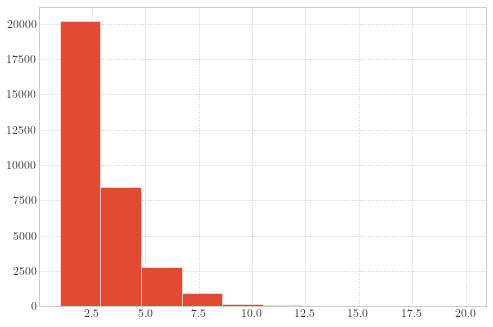

count    32509.00000
mean         2.52364
std          1.75981
min          1.00000
25%          1.00000
50%          2.00000
75%          3.00000
max         20.00000
Name: MarketID, dtype: float64

Number of players in at least 6 different experimental sessions: 2034


In [66]:
n_markets = df_playerProfile.groupby('userid_profile')['MarketID'].nunique()

_ = plt.hist(n_markets)
_ = plt.show()

n_markets.describe()

print('Number of players in at least 6 different experimental sessions: {}'.format(sum(n_markets > 5)))

**Within markets, how many periods did the players participate in? How many different valuation tuples were they assigned within each market?**

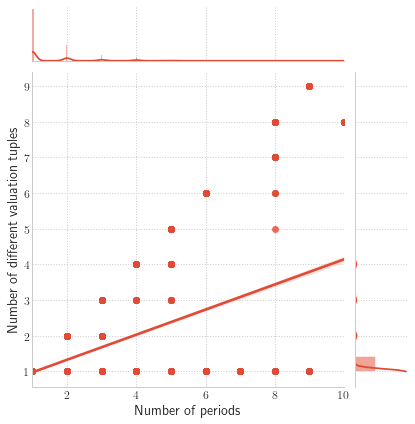

In [67]:
n_periods = df_playerProfile.groupby(['userid_profile', 'MarketID'])['period'].nunique()
n_valuationTuples = df_playerProfile.groupby(['userid_profile', 'MarketID'])['valuecost'].nunique()

_ = sns.jointplot(x=n_periods, y=n_valuationTuples, kind='reg')
_ = plt.xlabel('Number of periods')
_ = plt.ylabel('Number of different valuation tuples')
_ = plt.show()

Number of different valuation tuples assigned to the participants

In [68]:
n_sides = df_playerProfile.groupby(['userid_profile', 'MarketID'])['role'].nunique()
n_sides.describe()

count    82041.000000
mean         1.083495
std          0.276630
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: role, dtype: float64

**How many items did a subject trade with within a single trading period?**

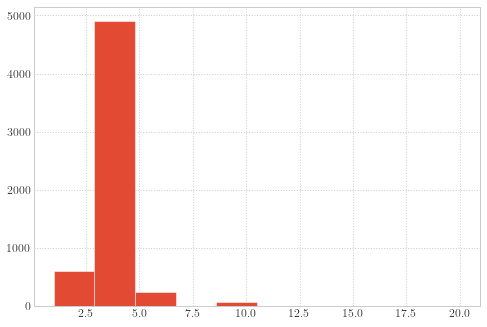

3     4846
2      302
1      302
5      199
10      68
4       50
6       39
15       2
20       1
Name: lenval, dtype: int64

count    5809.000000
mean        3.030298
std         1.066865
min         1.000000
25%         3.000000
50%         3.000000
75%         3.000000
max        20.000000
Name: lenval, dtype: float64

In [69]:
market_lenVals = df_playerProfile[['MarketID', 'lenval']].drop_duplicates()['lenval']

_ = plt.hist(market_lenVals)
_ = plt.show()

market_lenVals.value_counts()

market_lenVals.describe()

### Single-item double auctions

An average market involves trading with three goods; overall, there are **302 single-item** markets (note that the players' reservation prices and/or market sides need not be the same across the rounds).

In [70]:
singleItem_markets = df_playerProfile[df_playerProfile['lenval'] == 1]['MarketID'].drop_duplicates().tolist()

**161** of these markets are single-period, **141** are multi-period.

Assume that if a round was not recorded in the order book, no bids/asks were submitted. Accordingly, a market with bids and asks submitted only from round 2 onward is assumed to be multi-period.

count    302.000000
mean       2.016556
std        1.290030
min        1.000000
25%        1.000000
50%        1.000000
75%        3.000000
max        9.000000
Name: period, dtype: float64

1    161
3     77
2     29
4     23
5      9
9      1
7      1
6      1
Name: period, dtype: int64

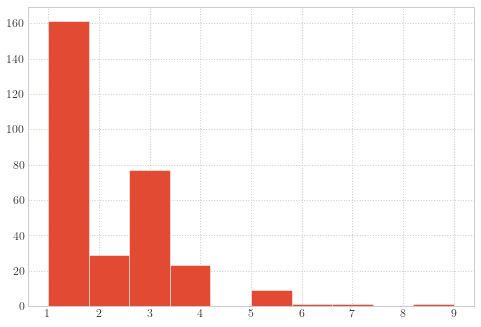

In [71]:
n_periods = df_playerProfile[df_playerProfile['MarketID'].isin(singleItem_markets)].groupby('MarketID')['period'].max()

_ = plt.hist(n_periods)
n_periods.describe()
n_periods.value_counts()

#### Multi-period single-item double auctions

In [72]:
groups = df_playerProfile[df_playerProfile['MarketID'].isin(singleItem_markets)].groupby('MarketID')
multiPeriod_singleItem_markets = groups.filter(lambda group: max(group['period']) > 1)

Do valuations change across these?

In [73]:
groups = multiPeriod_singleItem_markets.groupby(['MarketID', 'userid_profile'])['valuecost'].nunique()
groups = groups.reset_index()
groups = groups.rename({'valuecost': 'Number of different valuation tuples'}, axis=1)

In [74]:
groups

,MarketID,userid_profile,Number of different valuation tuples
0,33001,104337.0,1
1,33001,104356.0,1
2,33001,104370.0,1
3,33001,104375.0,1
4,33001,104376.0,1
...,...,...,...
2863,2539001,170863.0,4
2864,2539001,170915.0,4
2865,2539001,171191.0,4
2866,2539001,171655.0,4


Find markets with constant valuations across all rounds, i.e., markets where the maximum number of different valuation tuples per player amounts to 1.

In [75]:
nvalsMarkets = groups.groupby('MarketID')['Number of different valuation tuples'].max()

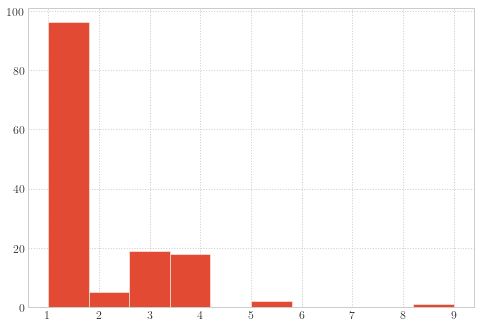

In [76]:
_ = plt.hist(nvalsMarkets)

In [77]:
nvalsMarkets.value_counts()

1    96
3    19
4    18
2     5
5     2
9     1
Name: Number of different valuation tuples, dtype: int64

In [78]:
nvalsMarkets.value_counts()

1    96
3    19
4    18
2     5
5     2
9     1
Name: Number of different valuation tuples, dtype: int64

**There are 96 single-item multi-period double auctions with constant valuations.**

In [79]:
constVal_multiPeriod_singleItem_markets = nvalsMarkets[nvalsMarkets == 1].index.tolist()

Number of periods in these markets

In [80]:
df_playerProfile[df_playerProfile['MarketID'].isin(constVal_multiPeriod_singleItem_markets)].groupby(['MarketID'])['period'].max().value_counts()

3    57
2    25
5     7
4     5
7     1
6     1
Name: period, dtype: int64

Number of players in these markets (as originally planned); recall that some participants took part in several experimental markets

In [81]:
df_playerProfile[df_playerProfile['MarketID'].isin(constVal_multiPeriod_singleItem_markets)].groupby('MarketID')['userid_profile'].nunique().value_counts().sort_index().rename_axis('Number of players').reset_index(name='Market counts')

,Number of players,Market counts
0,2,2
1,5,4
2,6,28
3,7,2
4,8,1
5,10,25
6,15,2
7,19,4
8,20,10
9,21,2


### Losses

**Percentage of bids/asks which would incur a loss to the player if they resulted in a deal**

In [82]:
df_B = df_orderBook[df_orderBook['side'] == 'Buyer'].dropna(subset=['bid'])
df_S = df_orderBook[df_orderBook['side'] == 'Seller'].dropna(subset=['bid'])

demand_B = df_B.apply(lambda row: row['valuation'] - row['bid'], axis=1)
demand_S = df_S.apply(lambda row: row['bid'] - row['valuation'], axis=1)

In [83]:
len(demand_B[demand_B < 0])/len(demand_B)*100
len(demand_S[demand_S < 0])/len(demand_S)*100

7.032392365443775

5.355735000901412

Single-item double auctions with fixed market sides and valuations

In [84]:
singleItem = [m.market_id for m in markets if (m.is_singleItem() == True) & (m.fixed_attributes() == True)]
df_single = df_orderBook[df_orderBook['treatment'].isin(singleItem)]

In [85]:
df_singleB = df_single[(df_single['side'] == 'Buyer')].dropna(subset=['bid'])
df_singleS = df_single[(df_single['side'] == 'Seller')].dropna(subset=['bid'])

demand_B = df_singleB.apply(lambda row: row['valuation'] - row['bid'], axis=1)
demand_S = df_singleS.apply(lambda row: row['bid'] - row['valuation'], axis=1)

In [86]:
len(demand_B[demand_B < 0])/len(demand_B)*100
len(demand_S[demand_S < 0])/len(demand_S)*100

7.512868251013033

5.646105357946871

**Percentage of bids/asks resulting in a deal which incurred loss to the buyer/seller**

In [87]:
df_B = df_orderBook[df_orderBook['side'] == 'Buyer'].dropna(subset=['bid','price'])
df_S = df_orderBook[df_orderBook['side'] == 'Seller'].dropna(subset=['bid', 'price'])

demand_B = df_B.apply(lambda row: row['valuation'] - row['price'], axis=1)
demand_S = df_S.apply(lambda row: row['price'] - row['valuation'], axis=1)

len(demand_B[demand_B < 0])/len(demand_B)*100
len(demand_S[demand_S < 0])/len(demand_S)*100

14.454275162518806

12.080744670894914

Repeated single-item double auctions with fixed market sides and valuations

In [88]:
df_singleB = df_single[(df_single['side'] == 'Buyer')].dropna(subset=['bid', 'price'])
df_singleS = df_single[(df_single['side'] == 'Seller')].dropna(subset=['bid', 'price'])

demand_B = df_singleB.apply(lambda row: row['valuation'] - row['price'], axis=1)
demand_S = df_singleS.apply(lambda row: row['price'] - row['valuation'], axis=1)

len(demand_B[demand_B < 0])/len(demand_B)*100
len(demand_S[demand_S < 0])/len(demand_S)*100

15.106874638937033

14.644714038128251

**Percentage of deals incurring loss to the buyer/seller/both**

In [89]:
demand = df_deals.apply(lambda row: min(row['buyervalue'] - row['price'], row['price'] - row['sellercost']), axis=1)
len(demand[demand < 0])/len(demand)*100

demand = df_deals[df_deals['MarketID'].isin(singleItem)].apply(lambda row: min(row['buyervalue'] - row['price'], row['price'] - row['sellercost']), axis=1)
len(demand[demand < 0])/len(demand)*100

26.24993700821413

29.54939341421144

# Ikica et al. data versus Lin et al. data

In [90]:
df = pd.read_csv('Data/Data.csv')

Use a single label to encode the session

In [91]:
df['treatment'] = df.apply(lambda row: '{} {}'.format(row['treatment'], row['game']), axis=1)

## General comparison

In [92]:
columns = pd.MultiIndex.from_product([['Lin et al.'], ['All', 'Single-item with fixed market roles and valuations']], names=['Data', 'DAs'])
index = pd.Index(range(1,6), name='Number of rounds')

df_comparison = pd.DataFrame(index=index, columns=columns)

for n_rounds in index:
    all_markets = [m for m in markets if (m.n_rounds == n_rounds)]
    all_players = []
    
    for m in all_markets:
        all_players.extend([p.player_id for p in m.players])
    
    all_players = set(all_players)
    
    df_comparison.loc[
        n_rounds,
        ('Lin et al.', 'All')
    ] = '{} ({})'.format(len(all_markets), len(all_players))

    single_markets = [m for m in all_markets if (m.is_singleItem() == True) & (m.fixed_attributes() == True)]
    single_players = []
    
    for m in single_markets:
        single_players.extend([p.player_id for p in m.players])
    
    single_players = set(single_players)
    
    df_comparison.loc[
        n_rounds,
        ('Lin et al.', 'Single-item with fixed market roles and valuations')
    ] = '{} ({})'.format(len(single_markets), len(single_players))
    
    df_comparison.loc[
        n_rounds,
        ('Ikica et al.', 'All')
    ] = '{} ({})'.format(
        len(df.groupby('treatment').filter(lambda g: max(g['round']) == n_rounds)['treatment'].drop_duplicates().index),
        df.groupby(['treatment']).filter(lambda g: max(g['round']) == n_rounds)['id'].nunique()
    )

all_markets = [m for m in markets if (m.n_rounds >= 6)]
all_players = []

for m in all_markets:
    all_players.extend([p.player_id for p in m.players])

all_players = set(all_players)
    
df_comparison.loc[
    '$\geq 6$',
    ('Lin et al.', 'All')
] = '{} ({})'.format(len(all_markets), len(all_players))

single_markets = [m for m in all_markets if (m.is_singleItem() == True) & (m.fixed_attributes() == True)]
single_players = []

for m in single_markets:
    single_players.extend([p.player_id for p in m.players])

single_players = set(single_players)

df_comparison.loc[
    '$\geq 6$',
    ('Lin et al.', 'Single-item with fixed market roles and valuations')
] = '{} ({})'.format(len(single_markets), len(single_players))

df_comparison.loc[
    '$\geq 6$',
    ('Ikica et al.', 'All')
] = '{} ({})'.format(
    len(df.groupby('treatment').filter(lambda g: max(g['round']) >= 6)['treatment'].drop_duplicates().index),
    df.groupby('treatment').filter(lambda g: max(g['round']) >= 6)['id'].nunique()
)

all_players = []

for m in markets:
    all_players.extend([p.player_id for p in m.players])
all_players = set(all_players)

df_comparison.loc['Total', ('Lin et al.', 'All')] = '{} ({})'.format(len(markets), len(all_players))

single_markets = [m for m in markets if (m.is_singleItem() == True) & (m.fixed_attributes() == True)]
single_players = []

for m in single_markets:
    single_players.extend([p.player_id for p in m.players])

single_players = set(single_players)

df_comparison.loc[
    'Total',
    ('Lin et al.', 'Single-item with fixed market roles and valuations')
] = '{} ({})'.format(len(single_markets), len(single_players))

df_comparison.loc[
    'Total',
    ('Ikica et al.', 'All')
] = '{} ({})'.format(len(df['treatment'].drop_duplicates().index), df['id'].nunique())

In [93]:
df_comparison

Data                Lin et al.  \
DAs                        All   
Number of rounds                 
1                 3807 (22105)   
2                  1238 (9516)   
3                   446 (4805)   
4                   232 (4141)   
5                     53 (940)   
$\geq 6$              33 (472)   
Total             5809 (32126)   

Data                                                                 \
DAs              Single-item with fixed market roles and valuations   
Number of rounds                                                      
1                                                        161 (1032)   
2                                                          25 (340)   
3                                                          57 (662)   
4                                                            5 (71)   
5                                                            7 (96)   
$\geq 6$                                                     2 (83)   
Total                                                    257 (1917)   

Data             Ikica et al.  
DAs                       All  
Number of rounds               
1                       0 (0)  
2                       0 (0)  
3                       0 (0)  
4                       0 (0)  
5                       0 (0)  
$\geq 6$           104 (1751)  
Total              104 (1751)

In [94]:
print(df_comparison.to_latex(escape=False))

\begin{tabular}{llll}
\toprule
Data & \multicolumn{2}{l}{Lin et al.} & Ikica et al. \\
DAs &           All & Single-item with fixed market roles and valuations &          All \\
Number of rounds &               &                                                    &              \\
\midrule
1                &  3807 (22105) &                                         161 (1032) &        0 (0) \\
2                &   1238 (9516) &                                           25 (340) &        0 (0) \\
3                &    446 (4805) &                                           57 (662) &        0 (0) \\
4                &    232 (4141) &                                             5 (71) &        0 (0) \\
5                &      53 (940) &                                             7 (96) &        0 (0) \\
$\geq 6$         &      33 (472) &                                             2 (83) &   104 (1751) \\
Total            &  5809 (32126) &                                         257 (1917)

**Percentage of bids/asks resulting in a deal**

In [95]:
print('Lin et al.')
df_orderBook['price'].count()/len(df_orderBook)

print('Ikica et al.')
df['price'].count()/len(df)

Lin et al.


0.39253237027868676

Ikica et al.


0.15289514504665108

## Hypothesis testing

Extract buyer and seller valuations

In [96]:
def get_valuations(df):
    '''Extract buyer and seller valuations.'''
    valuations = {}
    
    for side, df_side in df.groupby(['side']):
        side_valuations = df_side[['id', 'valuation']].drop_duplicates()['valuation'].tolist()
    
        if side == 'Buyer':
            side_valuations.sort(reverse=True)
        else:
            side_valuations.sort()
    
        valuations[side] = side_valuations
    
    return valuations

In [97]:
all_valuations = {}

for (treatment, rnd), dfr in df.groupby(['treatment', 'round']):
    all_valuations[treatment, rnd] = get_valuations(dfr)

for (mid, period), dfm in tqdm(df_playerProfile.groupby(['MarketID', 'period'])):
    buyer_valuations = []
    seller_valuations = []

    for idx, dfi in df_orderBook[(df_orderBook['treatment'] == mid) & (df_orderBook['round'] == period)].groupby('id'):
        vals = dfm[dfm['userid_profile'] == idx]['valuecost'].iloc[0]
        side = dfi['side'].iloc[0]

        if np.isnan(dfi['price'].iloc[-1]):
            nvals = min(dfi['price'].count()+1, len(vals))
        else:
            nvals = min(dfi['price'].count(), len(vals))

        if (side == 'Buyer'):
            buyer_valuations.extend(vals[:nvals])
        elif (side == 'Seller'):
            seller_valuations.extend(vals[:nvals])
    
    all_valuations[mid, period] = {'Buyer': buyer_valuations, 'Seller': seller_valuations}

100%|██████████████████████████████████████████████████████████████████████████████| 9023/9023 [01:51<00:00, 80.86it/s]


Extract CE ranges and gains of trade

In [98]:
def get_equilibrium(buyer_valuations, seller_valuations):
    '''Extract the equilibrium price range, the gains of trade,
    and the equilibrium quantity corresponding to a given experimental market.'''
    
    buyer_valuations.sort(reverse=True)
    seller_valuations.sort()
    
    GOT = 0
    eq_quantity = min(len(buyer_valuations), len(seller_valuations))
    
    # Find the intersection of supply and demand curves and compute the corresponding gains of trade 
    for i in range(eq_quantity):
        if seller_valuations[i] > buyer_valuations[i]:
            eq_quantity = i
            break
        else:
            GOT += buyer_valuations[i] - seller_valuations[i]
    
    EPR = [seller_valuations[eq_quantity-1], buyer_valuations[eq_quantity-1]]
        
    return EPR, GOT, eq_quantity

In [99]:
CE_all = {}
GOT_all = {}

for (mid, period), dfm in tqdm(df_playerProfile.groupby(['MarketID', 'period'])):
    buyer_valuations =  all_valuations[mid, period]['Buyer']
    seller_valuations =  all_valuations[mid, period]['Seller']
    
    EPR, GOT, eq_quantity = get_equilibrium(buyer_valuations, seller_valuations)

    CE_all[mid, period] = EPR
    GOT_all[mid, period] = GOT
    
for (treatment, rnd), dft in df.groupby(['treatment', 'round']):
    buyer_valuations =  all_valuations[treatment, rnd]['Buyer']
    seller_valuations =  all_valuations[treatment, rnd]['Seller']
    
    EPR, GOT, eq_quantity = get_equilibrium(buyer_valuations, seller_valuations)

    CE_all[treatment, rnd] = EPR
    GOT_all[treatment, rnd] = GOT

100%|███████████████████████████████████████████████████████████████████████████| 9023/9023 [00:00<00:00, 31693.87it/s]


In [100]:
def distances_to_EPR(deals, treatment, rnd):
    prices = deals['price']
    
    [epr1, epr2] = CE_all[treatment, rnd]

    distances = []
    
    for price in prices:    
        if price > epr2:
            distances.append(price - epr2)
        elif price < epr1:
            distances.append(price - epr1)
        else:
            distances.append(0)
    
    return distances

def distances_midCE(deals, treatment, rnd):
    prices = deals['price']
    
    [epr1, epr2] = CE_all[treatment, rnd]
    midpoint = np.mean([epr1, epr2])

    distances = []
    
    for price in prices:    
        distances.append((price - midpoint)/midpoint)
    
    return distances

def allocative_efficiency(deals, treatment, rnd):
    GOT = GOT_all[treatment, rnd]

    AE = (sum(deals[deals['side'] == 'Buyer']['valuation']) - sum(deals[deals['side'] == 'Seller']['valuation']))/GOT
    
    if AE > 1:
        print(treatment, rnd, AE, GOT)
        print(len(deals))
        display(deals)
    
    return AE

def Selten_index(deals, treatment, rnd, output='SI', eps1=0, eps2=0):
    prices = deals['price']
    
    [epr1, epr2] = CE_all[treatment, rnd]
    
    epr1 -= eps1
    epr2 += eps2
    
    if len(prices) > 0:
        EPR_prices = sum((epr1 <= prices) & (prices <= epr2)) # realised prices in EPR
        all_prices = prices.count() # all realised prices

        r = EPR_prices/all_prices

        width_EPR = epr2 - epr1 + 1

        valuations = all_valuations[treatment, rnd]
        
        possible_trade_pairs = [(vals, valb) for (vals, valb) in itertools.product(valuations['Seller'], valuations['Buyer']) if vals <= valb]

        nOutcomes = [valb - vals + 1 for (vals, valb) in possible_trade_pairs]
        nOutcomes = np.mean(nOutcomes)

        if width_EPR < nOutcomes:
            a = width_EPR/nOutcomes
        else:
            a = 1
        
        m = r-a

    else:
        m = np.nan
        r = np.nan
        a = np.nan
    
    if output == 'SI':
        out = m
    elif output == 'hitRate':
        out = r
    elif output == 'area':
        out = a
    elif output == 'all':
        out = m, r, a
        
    return out

In [101]:
def get_yvals(df, fun):
    deals = df.dropna(subset=['price'])
    all_yvals = []
    means = []
    
    # First-round opening prices
    yvals = []    
    
    for treatment, df_game in deals[deals['round'] == 1].groupby(['treatment']):
        yvals.append(fun(df_game[df_game['match_time'] == df_game['match_time'].min()], treatment, 1))

    yvals = list(flatten_list(yvals))
    all_yvals.append(yvals)
    means.append(np.nanmean(yvals))    
    
    # First-round closing prices
    yvals = []

    for treatment, df_game in deals[deals['round'] == 1].groupby(['treatment']):
        yvals.append(fun(df_game[df_game['match_time'] == df_game['match_time'].max()], treatment, 1))

    yvals = list(flatten_list(yvals))
    all_yvals.append(yvals)    
    means.append(np.nanmean(yvals))        
    
    # Rounds 2 to 5
    yvals = []

    for (treatment, rnd), df_game in deals[deals['round'].isin(range(2,6))].groupby(['treatment', 'round']):
        yvals.append(fun(df_game, treatment, rnd))

    yvals = list(flatten_list(yvals))
    all_yvals.append(yvals)    
    means.append(np.nanmean(yvals))
    
    # Rounds from 6 on
    yvals = []

    for (treatment, rnd), df_game in deals[deals['round'] >= 6].groupby(['treatment', 'round']):
        yvals.append(fun(df_game, treatment, rnd))

    yvals = list(flatten_list(yvals))
    all_yvals.append(yvals)    
    means.append(np.nanmean(yvals))
    
    return all_yvals, means

def mean_evolution(ax, means, fun, **kwargs):
    kwargs_fun = kwargs.get('extra_params', {})
            
    colour = kwargs.get('colour')
    label = kwargs.get('label')
    linewidth = kwargs.get('linewidth')
    markersize = kwargs.get('markersize')
    
    rounds = range(1, len(means)+1)
    _ = ax.plot(rounds, means, color=colour, marker='o', markersize=markersize, label='{}'.format(label), linewidth=linewidth, zorder=100)

def grid_layout(ax, fun):
    xticks = range(1,11)
    _ = ax.set_xticks(xticks)
    _ = ax.set_xticklabels(xticks, size=12)

    if (fun == distances_to_EPR) or (fun == distances_midCE):
        _ = ax.axhline(y=0, linestyle='solid', linewidth=5.0, color='darkgrey', alpha=0.8, zorder=0)

        yticks = np.arange(-0.2,0.205,0.1).round(1)
        _ = ax.set_ylim(min(yticks)-0.05,max(yticks)+0.05)

    elif fun == allocative_efficiency:
        _ = ax.axhline(y=1, linestyle='solid', linewidth=5.0, color='darkgrey', alpha=0.8, zorder=0)        
        
        yticks = np.arange(0,1.1,0.2).round(1)
        _ = ax.set_ylim(min(yticks)-0.1,max(yticks)+0.1)
    
    elif (fun == Selten_index):
        _ = ax.axhline(y=0, linestyle='solid', linewidth=5.0, color='darkgrey', alpha=0.8, zorder=0)        
        
        yticks = np.arange(-0.2,0.205,0.1).round(1)
        _ = ax.set_ylim(min(yticks)-0.05,max(yticks)+0.05)
    
    _ = ax.set_yticks(yticks)
    _ = ax.set_yticklabels(yticks, size=12)

In [102]:
singleItem = [m.market_id for m in markets if (m.is_singleItem() == True) & (m.fixed_attributes() == True)]
df_orderBook_SI = df_orderBook[df_orderBook['treatment'].isin(singleItem)].copy()

def demand(row):
    if (row['side'] == 'Buyer'):
        demand = row['valuation'] - row['bid']
    elif (row['side'] == 'Seller'):
        demand = row['bid'] - row['valuation']
    return demand

df_orderBook_SI['demand'] = df_orderBook_SI.apply(demand, axis=1)

In [103]:
df_orderBook_SI['strictVals'] = True

for (mid, rnd, mt), dfp in df_orderBook_SI.dropna(subset=['price']).groupby(['treatment', 'round', 'match_time']):
    if len(dfp) != 2:
        print('More than one deals made at time {} in round {} of market {}'.format(mt, rnd, mid))
    else:
        if (dfp['demand'] < 0).any():
            df_orderBook_SI.loc[dfp.index, 'strictVals'] = False

In [104]:
def Wilcoxon_oneSided(vals, alternative, M0):
    vals = [v-M0 for v in vals]
    w, p = stats.wilcoxon(vals, alternative=alternative, zero_method='pratt')
    
    return p

def Wilcoxon_plot(ax, all_yvals, alternative, M0_list, palette, title):
    _ = ax.set_title(title)
    _ = ax.axhline(0.05, linestyle='dashed', linewidth=2, color='gray')

    rounds = range(1, len(all_yvals)+1)    
    
    for idx, M0 in enumerate(M0_list):
        pvals = []

        for vals in all_yvals:
            if alternative == 'equivalence':
                p1 = Wilcoxon_oneSided(vals, 'greater', -M0)
                p2 = Wilcoxon_oneSided(vals, 'less', M0)
                p = max(p1,p2)
            else:
                p = Wilcoxon_oneSided(vals, alternative, M0)
            
            pvals.append(p)
        
        _ = ax.plot(rounds, pvals, marker='o', markersize=8, label=abs(M0), color=palette[idx])

    _ = ax.set_ylabel('$p$-value')
    _ = ax.label_outer()
    _ = ax.legend(title=r'$\varepsilon$', title_fontsize=12)

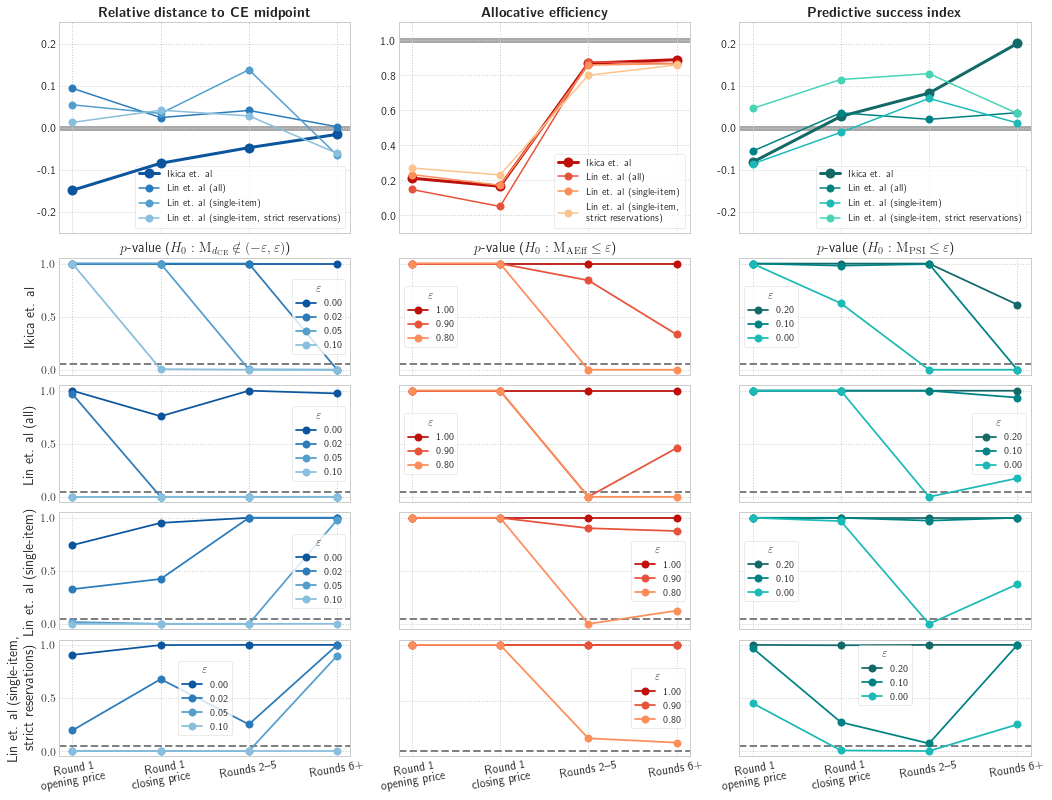

In [105]:
from textwrap import fill

blue_palette = sns.color_palette('Blues_r', n_colors=6) # used for plotting distance to CE
red_palette = sns.color_palette('OrRd_r', n_colors=5) # used for plotting allocative efficiency
teal_palette = sns.color_palette(['#136868', '#008282', '#1cbab7', '#48D3B7', '#68EACE', '#96F8E5']) # used for plotting Selten index

fig, ax = plt.subplots(5,3, figsize=(14.5,11), sharex=True, constrained_layout=True, gridspec_kw={'height_ratios': [1.8, 1, 1, 1, 1]})
ax = ax.flatten()

datasets = [df, df_orderBook, df_orderBook_SI, df_orderBook_SI[df_orderBook_SI['strictVals']]]
labels = ['Ikica et. al', 'Lin et. al (all)', 'Lin et. al (single-item)', 'Lin et. al (single-item, strict reservations)']

cols = [(0, distances_midCE, blue_palette, 'Relative distance to CE midpoint'),
        (1, allocative_efficiency, red_palette, 'Allocative efficiency'),
        (2, Selten_index, teal_palette, 'Predictive success index')]

# rows = [('equivalence', np.arange(0,0.21,0.05).round(2), blue_palette, r'$p$-value ($H_0 : \mathrm{M}_{d_{\mathrm{CE}}} \notin (-\varepsilon, \varepsilon)$)'),
#         ('greater', np.arange(1,0.79,-0.05).round(2), red_palette, r'$p$-value ($H_0 : \mathrm{M}_{\mathrm{AEff}} \leq \varepsilon$)'),
#         ('greater', np.arange(0.2,-0.01,-0.05).round(2), teal_palette, r'$p$-value ($H_0 : \mathrm{M}_{\mathrm{PSI}} \leq \varepsilon$)')
#         ]

rows = [('equivalence', [0, 0.02, 0.05, 0.10], blue_palette, r'$p$-value ($H_0 : \mathrm{M}_{d_{\mathrm{CE}}} \notin (-\varepsilon, \varepsilon)$)'),
        ('greater', [1, 0.9, 0.8], red_palette, r'$p$-value ($H_0 : \mathrm{M}_{\mathrm{AEff}} \leq \varepsilon$)'),
        ('greater', [0.20, 0.10, 0], teal_palette, r'$p$-value ($H_0 : \mathrm{M}_{\mathrm{PSI}} \leq \varepsilon$)')
        ]

for idx, (data, label) in enumerate(zip(datasets, labels)):
    deals = data.dropna(subset=['price'])    
    
    for (col, fun, palette, title) in cols:
        grid_layout(ax[col], fun)

        all_yvals, means = get_yvals(deals, fun)

        if (col == 1):
            loc = 'upper left'
            _label = fill(label, 30)
        else:
            loc = 'lower right'
            _label = label
        
        if (idx == 0):
            linewidth = 3
            markersize = 10
        else:
            linewidth = 1.5
            markersize = 8
        
        mean_evolution(
            ax[col], means, fun,
            **{'colour': palette[idx], 'label': _label, 'linewidth': linewidth, 'markersize': markersize}
        )
        
        leg = ax[col].legend(loc='lower right', fontsize=10, framealpha=0.8)
        _ = ax[col].set_title(bold_text(title), fontsize=14)
        
        axi = ax[3*(idx+1) + col]
        
        Wilcoxon_plot(axi, all_yvals, *rows[col])
        
        if idx > 0:
            _ = axi.set_title('')
        
        for t in ax[3*(idx+1) + col].get_legend().texts:
            t.set_text('{:.2f}'.format(float(t.get_text())))
            
    _ = ax[3*(idx+1)].set_ylabel(fill(labels[idx],30))
    
for axi in ax:
    _ = axi.set_xticks(range(1,5))
    _ = axi.set_xticklabels([r'Round 1\\opening price', r'Round 1\\closing price', r'Rounds 2--5', r'Rounds 6+'], rotation=10)

_ = plt.savefig('Figures/p_values.pdf', bbox_inches='tight', transparent=True)

## Convergence towards CE

**Lin et al. data: CE based on the players actually present in the round**

In [106]:
yvals, means = get_yvals(df_orderBook, distances_midCE)

Round 1 opening prices

In [107]:
np.mean(yvals[0])
np.median(yvals[0])

0.09348576302167012

0.010869565217391304

**Lin et al. data:  CE based on the original design of the market**

In [108]:
planned_valuations = {}

for (mid, period), dfm in tqdm(df_playerProfile.groupby(['MarketID', 'period'])):
    buyer_valuations = []
    seller_valuations = []

    for idx, dfi in dfm.groupby('userid_profile'):
        vals = dfi['valuecost'].iloc[0]
        side = dfi['role'].iloc[0]

        if (side == 'buyer'):
            buyer_valuations.extend(vals)
        elif (side == 'seller'):
            seller_valuations.extend(vals)
            
    planned_valuations[mid, period] = {'Buyer': buyer_valuations, 'Seller': seller_valuations}

100%|█████████████████████████████████████████████████████████████████████████████| 9023/9023 [00:22<00:00, 407.42it/s]


In [109]:
CE_planned = {}
GOT_planned = {}

for (mid, period), dfm in tqdm(df_playerProfile.groupby(['MarketID', 'period'])):
    buyer_valuations =  planned_valuations[mid, period]['Buyer']
    seller_valuations =  planned_valuations[mid, period]['Seller']
    
    EPR, GOT, eq_quantity = get_equilibrium(buyer_valuations, seller_valuations)

    CE_planned[mid, period] = EPR
    GOT_planned[mid, period] = GOT

100%|███████████████████████████████████████████████████████████████████████████| 9023/9023 [00:00<00:00, 31398.21it/s]


In [110]:
def distances_midCE_planned(deals, treatment, rnd):
    prices = deals['price']
    
    [epr1, epr2] = CE_planned[treatment, rnd]
    midpoint = np.mean([epr1, epr2])

    distances = []
    
    for price in prices:    
        distances.append((price - midpoint)/midpoint)
    
    return distances

In [111]:
yvals, means = get_yvals(df_orderBook, distances_midCE_planned)

Round 1 opening prices

In [112]:
np.mean(yvals[0])
np.median(yvals[0])

0.09450278597553688

0.006896551724137931

**Ikica et al. data: CE based on the players actually present in the round**

In [113]:
yvals, means = get_yvals(df, distances_midCE)

Round 1 opening prices

In [114]:
np.mean(yvals[0])
np.median(yvals[0])

-0.14922149492846215

-0.1583710407239819

Round 1 closing prices

In [115]:
np.mean(yvals[1])
np.median(yvals[1])

-0.08483135387403573

-0.09221466364323508

Across rounds

In [116]:
for rnd, dfr in df.groupby('round'):
    distances = []

    for mid, dfm in dfr[(dfr['price'].notna())].groupby('treatment'):
        CE = CE_all[mid, rnd]
        CE_midpoint = int(np.mean(CE))
    
        distances.extend(((dfm['price']-CE_midpoint)/CE_midpoint).values)
    
    print('Round {}'.format(rnd))
    np.mean(distances), np.median(distances)

Round 1


(-0.09306310100593397, -0.09090909090909091)

Round 2


(-0.06193763746747664, -0.06666666666666667)

Round 3


(-0.046115767190937254, -0.0423728813559322)

Round 4


(-0.042789502465251705, -0.037037037037037035)

Round 5


(-0.034001512895931986, -0.027777777777777776)

Round 6


(-0.02451873709679432, -0.025423728813559324)

Round 7


(-0.025227904401511556, -0.024390243902439025)

Round 8


(-0.022018575080662767, -0.019417475728155338)

Round 9


(-0.021594790675800748, -0.016666666666666666)

Round 10


(-0.015608399513287026, -0.008231707317073171)

Round 11


(-0.026985852975782206, -0.02654867256637168)

Round 12


(-0.0234337155322685, -0.04424778761061947)

Round 13


(-0.02790816980890087, -0.03232195533080489)

Round 14


(-0.008775479891460953, -0.02654867256637168)

Round 15


(-0.011062866469471135, -0.02654867256637168)

Round 16


(0.018072385482927996, -0.008849557522123894)

Round 17


(-0.002567799591130242, -0.02654867256637168)

Round 18


(0.002707296784322303, -0.0048543689320388345)

Round 19


(0.020493229996885253, -0.01818181818181818)

Round 20


(0.0015241713302840496, -0.01818181818181818)

Round 21


(0.008179134243143543, -0.025986200689965502)

Round 22


(-0.009484106668338366, -0.02236524537409493)

Round 23


(-0.012002720178941804, -0.01818181818181818)

Round 24


(0.007632111806794372, 0.0)

Round 25


(-0.004984704468480279, -0.01327433628318584)

Round 26


(0.009671195733142636, -0.004424778761061947)

Round 27


(0.012899335041665426, 0.0)

Round 28


(0.013343997145459242, 0.0)

Round 29


(0.003597278414515814, 0.017699115044247787)

Round 30


(-0.006008326764561678, 0.004424778761061947)

Round 31


(0.008712990276412104, 0.017699115044247787)

Round 32


(0.015693190508824725, 0.017699115044247787)

Round 33


(0.027607608862637027, 0.041171512852928784)

Round 34


(0.02974913946441457, 0.027777777777777776)

Round 35


(0.01678080017826074, 0.017699115044247787)

Round 36


(0.01946790918029856, 0.022738446411012782)

Round 37


(0.008942400676109446, 0.02716322517207473)

Round 38


(0.004709140915374081, 0.018518518518518517)

Round 39


(0.021204850868567684, 0.027777777777777776)

Round 40


(0.029169409298130142, 0.04485116653258246)

Round 41


(0.014945144661958822, 0.017699115044247787)

Round 42


(0.020483467482313188, 0.018518518518518517)

Round 43


(0.0171167440250577, 0.01835016835016835)

Round 44


(0.031737507821578616, 0.04485116653258246)

Round 45


(0.020952891749351926, 0.03601278269419862)

Round 46


(0.027188687627142973, 0.02716322517207473)

Round 47


(0.016794208598748805, 0.018518518518518517)

Round 48


(0.01686278174612849, 0.023148148148148147)

Round 49


(0.01684790705567928, 0.018518518518518517)

Round 50


(0.01546952496268667, 0.018108816781383152)